# PROBLEMA DE NEGÓCIO

**Company Name:**

Insurance All Company

---

**What the Company do?**

Sell health insurance to its customers.

---

**What's the business problem?**

The company is trying to know which are the best customers to offer its new product, auto insurance.

---

**Which are the main strategy?**

The company will call initially 5.000 customers, so we need to know which to call.

---

**What kind of question we need to answer?**



1.   Qual a **porcentagem de clientes**, interessados em adquirir o seguro de veículo, que o time de vendas conseguirá fazendo **5.000 ligações**? E qual **retorno financeiro**, se comparado ao **modelo randômico**, se cada seguro de veículo custar **1000 reais**?

2.   E se **aumentarmos** a quantidade de ligações para **10.000**?

3.   E se agora, **aumentarmos** para **20.000** ligações?



## Solution Planning

**What is the solution?**

We need to develop a machine learning model that rank the customers based on his probabilities to acquire his new product, auto insurance.

---

**How we going to deliver the solution?**

We going to make an API that return to our company which are the score of each customer based on machine learning model that rank them and deploy it in a cloud system

---

**What about it hosting?**

The API will be hosting on Heroku platform:

https://health-insurance-score-27.herokuapp.com/predict

---

**Which are the INPUTS?**

*   **Id** : Unique ID for the customer
*   **Gender** : Gender of the customer
*   **Age** : Age of the customer
*   **Driving License** : 0 = Customer does not have DL, 1 = Customer already has DL
*   **Region Code** : Unique code for the region of the customer
*   **Previously Insured** : 1 = Customer already has Vehicle Insurance, 0 = Customer doesn't have Vehicle Insurance
*   **Vehicle Age** : Age of the Vehicle
*   **Vehicle Damage** : 1 = Customer got his/her vehicle damaged in the past. 0 = Customer didn't get his/her vehicle damaged in the past.
*   **Annual Premium** : The amount customer needs to pay as premium in the year
*   **Policy Sales Channel** : Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
*   **Vintage** : Number of Days, Customer has been associated with the company
*   **Response** : 1 = Yes, 0 = No
---

**Which are the OUTPUTS?**

All above, except **Response** plus:
*   **Score**

## Process Planning


**Where is the data?**

The data is available on **AWS** platform

---

**Which SGBD?**

Postgres

**CREDENTIALS:**
*   HOST = comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com
*   PORT = 5432
*   Database = comunidadedsdb
*   Username = member
*   Password = cdspa

## Tools Planning

We going to use **Python** and its libraries to collect, **visualize**, **prepare**, **transform**, **select**, **modeling** and **predict** the probabilities of auto insurance **acquisition**

---

**STEPS PLANNING**

*   **Data Description** - to know our dataset
*   **Feature Engineering** - some hypothesis to try to make some insights
*   <s>Feature Filtering</s>
*   **Exploratory Data Analysis** - to undestand the feature relevance to our business model
*   **Data Preparation** - rescaling, encoding and transforming
*   **Feature Selection** - get to know some relevants features
*   **Machine Learning Modeling** - to test some machine learning models
*   **Cross Validation** - to make cross validation of selected models with best performance
*   **Hyperparameter Fine Tunning** - to find best parameters to our selected models
*   **Business Questions** - to convert  ML metrics to business model
*   Deploy - to make our API and deploy it on Heroku platform


# 0.0. IMPORTS

## 0.0.0 LIBRARIES

In [ ]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import scikitplot        as skplt
import xgboost           as xgb
import random            as rd
import psycopg2 as pg
import pickle
import requests
import json
import math
import random
import warnings
import os

from google.colab                import drive
from IPython.core.display        import HTML
from IPython.display             import Image
from tabulate                    import tabulate
from sklearn.ensemble            import RandomForestClassifier
from lightgbm                    import LGBMClassifier
from sklearn.neighbors           import KNeighborsClassifier
from sklearn.naive_bayes         import GaussianNB
from sklearn.linear_model        import LogisticRegression
from scipy                       import stats                       as ss
from matplotlib                  import pyplot                      as plt
from sklearn                     import preprocessing               as pp
from sklearn                     import model_selection             as ms
from sklearn                     import ensemble                    as en
from sklearn                     import neighbors                   as nh
from sklearn                     import linear_model                as lm
from sklearn                     import model_selection             as ms 
from sklearn                     import metrics                     as m
from scikitplot                  import metrics                     as mt

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.0.1. Helper Functions

### Models

In [ ]:
def models_train( models, x_train, y_train, x_test, y_test, predict = 'predict', metric = 'regression', verbose=1):
    metrics = pd.DataFrame()
    for model in models:
        print( model.__class__.__name__ )
        model.fit( x_train, y_train )
        if predict == 'predict':
            yhat = model.predict( x_test )
        elif predict == 'predict_proba':
            yhat = model.predict_proba( x_test )
            yhat = yhat[:, 1]
        
        if metric == 'regression':
            metrics = metrics.append( regression_metrics( model.__class__.__name__, y_test, yhat, verbose ) )
        elif metric == 'multiClass':
            metrics = metrics.append( multi_class_metrics( model.__class__.__name__, y_test, yhat, verbose ) )
        elif metric == 'binaryClass':
            metrics = metrics.append( ranking_class_metrics( model.__class__.__name__, y_test, yhat, verbose ) )
            
    return metrics

### Metrics

In [ ]:
def numerical_attributes( data ):
    
    # central tendency (quantile, median) & dispersion - std, min, max, range, skew, kurtosis
    d0 = pd.DataFrame( data.apply( lambda x: x.quantile( 0 ) ) ).T
    d1 = pd.DataFrame( data.apply( lambda x: x.quantile( 0.25 ) ) ).T
    d2 = pd.DataFrame( data.apply( lambda x: x.quantile( 0.50 ) ) ).T
    d3 = pd.DataFrame( data.apply( lambda x: x.quantile( 0.75 ) ) ).T
    d4 = pd.DataFrame( data.apply( lambda x: x.quantile( 1 ) ) ).T 
    d5 = pd.DataFrame( data.apply( lambda x: x.max() - x.min() ) ).T
    d6 = pd.DataFrame( data.apply( np.mean ) ).T 
    d7 = pd.DataFrame( data.apply( lambda x: x.std() ) ).T
    d8 = pd.DataFrame( data.apply( lambda x: x.skew() ) ).T 
    d9 = pd.DataFrame( data.apply( lambda x: x.kurtosis() ) ).T
    
    
    # concatenar
    aux = pd.concat( [d0, d1, d2, d3, d4, d5, d6, d7, d8, d9] ).T.reset_index()
    aux.columns = ['ATTRIBUTES', 'MIN', 'Q1', 'MEDIAN', 'Q3', 'MAX', 'RANGE', 'MEAN', 'STD', 'SKEW', 'KURTOSIS']
    return aux

def multi_class_metrics( model, y_val, yhat, verbose = 0 ):
    
    model = pd.DataFrame( [model] ).T

    # Precision Score
    precision = m.precision_score( y_val, yhat )
    df_precision = pd.DataFrame( [precision] ).T
    
    #Recall Score
    recall = m.recall_score( y_val, yhat )
    df_recall = pd.DataFrame( [recall] ).T
    
    # F1 Score
    f1 = m.f1_score( y_val, yhat )
    df_f1 = pd.DataFrame( [f1] ).T
    
    # Matthews Correlation
    mcc = m.matthews_corrcoef( y_val, yhat )
    mccdf = pd.DataFrame( [mcc] )    
    
    metrics = pd.concat( [model, df_f1, df_precision, df_recall,  mccdf] ).T.reset_index()
    metrics.columns=['Index', 'Model', 'F1', 'Precision', 'Recall', 'Matthew Correlation']
    metrics.drop( ['Index'], axis=1 )
    if verbose == 1:
        print( 'Precision Score: {}'.format( precision ) )
        print( 'Recall Score: {}'.format( recall ) )
        print( 'F1 Score: {}'.format( f1 ) )
        print( 'Matthew Correlation Score: {}'.format( mcc ) )
        
        # Classification Report
        print( m.classification_report( y_val, yhat ) )

        # Confusion Matrix
        mt.plot_confusion_matrix( y_val, yhat, normalize=False, figsize=( 12, 12 ) )
        
    return metrics

def ranking_class_metrics( model, y_val, yhat, verbose = 1 ):
    
    model = pd.DataFrame( [model] ).T

    # AUC_ROC
    roc = m.roc_auc_score( y_val, yhat )
    rocdf = pd.DataFrame( [roc] )
    
    # TopK Score
    knum = y_val.value_counts().count() - 1
    topk = m.top_k_accuracy_score( y_val, yhat, k = knum )
    topkdf = pd.DataFrame( [topk] )    
    
    metrics = pd.concat( [model, rocdf, topkdf] ).T.reset_index()
    metrics.columns = ['Index','Model','ROC AUC','Top K Score']
    metrics.drop( ['Index'], axis = 1 )
    if verbose == 1:
        print( 'ROC AUC: {}'.format( roc ) )
        print( 'Top K Score: {}'.format( topk ) )
        # Classification Report
        print( m.classification_report( y_val, yhat ) )
        # Confision Matrix
        mt.plot_confusion_matrix( y_val, yhat, normalize = False, figsize = ( 12, 12 ) )
        
    return metrics

def regression_metrics( model, y_val, yhat, verbose = 1 ):
    
    model = pd.DataFrame( [model] ).T
    
    # Accuracy
    acc = m.accuracy_score(y_val,yhat)
    df_acc = pd.DataFrame( [acc] ).T

    # Balanced Accuracy
    balanced = m.balanced_accuracy_score( y_val, yhat )
    df_balanced = pd.DataFrame( [balanced] ).T

    # Kappa Metrics
    kappa = m.cohen_kappa_score( y_val, yhat )
    df_kappa = pd.DataFrame( [kappa] ).T
    
    metrics = pd.concat( [model, df_acc, df_balanced, df_kappa] ).T.reset_index()
    metrics.columns = ['Index', 'Model', 'Accuracy', 'Balanced Accuracy', 'Kappa Score']
    metrics.drop( ['Index'], axis=1 )
    if verbose == 1:
        print( 'Accuracy: {}'.format( acc ) )
        print( 'Balanced Accuracy: {}'.format( balanced ) )
        print( 'Kappa Score: {}'.format( kappa ) )
        # Classification Report
        print( m.classification_report( y_val, yhat ) )
        # Confision Matrix
        mt.plot_confusion_matrix( y_val, yhat, normalize=False, figsize=( 12, 12 ) )
        
    return metrics

def precision_at_k( df, yhat_proba, target, perc = 0.25 ):
    k = int( np.floor( len( df ) * perc ) )
    
    df['score'] = yhat_proba[:, 1].tolist()
    df = df.sort_values( 'score', ascending=False )
    df = df.reset_index( drop=True )
    df['ranking'] = df.index + 1
    df['precision_at_k'] = df[target].cumsum() / df['ranking']

    return df.loc[k, 'precision_at_k']

def recall_at_k( df, yhat_proba, target, perc = 0.25):
    k = int( np.floor( len( df ) * perc ) )

    df['score'] = yhat_proba[:, 1].tolist()
    df = df.sort_values( 'score', ascending=False)
    df = df.reset_index( drop = True )
    df['recall_at_k'] = df[target].cumsum() / df[target].sum()
    
    return df.loc[k, 'recall_at_k']

def top_k_performance( df, proba, response, perc ):
    df_final_performance = pd.DataFrame()
    for i in proba:   
        for j in perc:
            k = int( np.floor( len( df ) * j ) )
            
            target_total = df[response].sum()
            
            df['score'] = i[:, 1].tolist()
            df = df.sort_values( 'score', ascending=False )
            
            target_at_k = df[response][:k].sum()
            target_perc = target_at_k / target_total

            precision = precision_at_k( df, i, response, j )
            recall = recall_at_k( df, i, response, j )

            df_final_performance = df_final_performance.append( {'Model': 'Model',
                                                                 'perc': j,
                                                                 'k': k,
                                                                 'precision': precision,
                                                                 'recall': recall,
                                                                 'target_total': target_total,
                                                                 'target_at_k': target_at_k,
                                                                 'perc_target': target_perc}, ignore_index=True)
    return df_final_performance

# Supress Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Graphics

In [ ]:
def graphic_percentage( ax, total ):
    for p in ax.patches:
        height = p.get_height()
        ax.text( p.get_x() + p.get_width() / 2.,
                 height,
                 '{:1.2f}'.format( height / total * 100 ),
                 ha = "center" ) 
    plt.show()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - ( k - 1 ) ** 2 / ( n - 1 )
    rcorr = r - ( r - 1 ) ** 2 / ( n - 1 )
    
    b = ( chi2corr / n ) / ( min( kcorr - 1, rcorr - 1) )
    
    v = np.sqrt( b )
    return v

def corr_cramer_v( categorical_attributes ):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict = {}

    for i in range( len( cat_attributes_list ) ):
        corr_list = []
        for j in range( len( cat_attributes_list ) ):
            ref = cat_attributes_list[i]
            feat = cat_attributes_list[j]
            corr = cramer_v( categorical_attributes[ref], categorical_attributes[feat] )
            corr_list.append( corr )
        corr_dict[ref]= corr_list
    return corr_dict

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings();

### Dataset Connection

In [ ]:
def connection_db():
    host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
    port = 5432
    database = 'comunidadedsdb'
    username = 'member'
    pwd = 'cdspa'
    
    conn = pg.connect( user = username,
                       password = pwd,
                       host = host,
                       port = port,
                       database = database)
    
    return conn

def query_db():
    query_tables = """
    SELECT *
    FROM pa004.users u INNER JOIN pa004.vehicle v ON ( u.id = v.id )
                       INNER JOIN pa004.insurance i ON ( u.id = i.id )
    """

    df = pd.read_sql( query_tables, conn )
    conn.close()
    return df

### Cross Validation

In [ ]:
def cross_validation( num_folds, modelName, model, x, y, metric ):
    kfold = ms.StratifiedKFold( n_splits = num_folds, shuffle = True, random_state = 27)

    cv_rf_metrics_list = pd.DataFrame()

    i = 1

    for train_cv, val_cv in kfold.split( x_train, y_train ):
        print( 'KFold Number {}/{}'.format( i, num_folds ) )

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit( x_train_fold, y_train_fold )

        yhat_model = model_fit.predict( x_val_fold )
        cv_rf_metrics_list = cv_rf_metrics_list.append( metric( '{} - {}/{}'.format( modelName, i, num_folds ), y_val_fold, yhat_model, 0 ) )

        i+=1
    return cv_rf_metrics_list

## 0.0.2. Loading data

In [ ]:
conn = connection_db()
df_raw = query_db()

In [ ]:
# df_raw = pd.read_csv( '/content/drive/MyDrive/Colab/data/pa004/train.csv' )
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]

In [ ]:
df_raw.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [ ]:
df1 = df_raw.copy()

In [ ]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0000,152.0000,1,< 1 Year,Yes,0,23367.0000,249,0
1,13,Female,41,15.0000,14.0000,1,1-2 Year,No,1,31409.0000,221,0
2,18,Female,25,35.0000,152.0000,1,< 1 Year,No,1,46622.0000,299,0
3,31,Female,26,8.0000,160.0000,1,< 1 Year,No,0,2630.0000,136,0
4,39,Male,45,8.0000,124.0000,1,1-2 Year,Yes,0,42297.0000,264,0


## 1.1. Rename Columns

In [ ]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [ ]:
cols_new = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
            'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured',
            'annual_premium', 'vintage', 'response']

df1.columns = cols_new

## 1.2. Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Columns: 12


## 1.3. Data Types

In [ ]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [ ]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## <s>1.5. Fillout NA</s>

## 1.6. Change Data Types

In [ ]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['annual_premium'] = df1['annual_premium'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

In [ ]:
df1['vehicle_damage'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

## 1.7 Check Balance Data

In [ ]:
df1['response'].value_counts( normalize=True )

0   0.8774
1   0.1226
Name: response, dtype: float64

## 1.8. Descriptive Statistics

In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.8.1. Numerical Atributes

In [ ]:
numerical_attributes( num_attributes )

,ATTRIBUTES,MIN,Q1,MEDIAN,Q3,MAX,RANGE,MEAN,STD,SKEW,KURTOSIS
0,id,1.0000,95278.0000,190555.0000,285832.0000,381109.0000,381108.0000,190555.0000,110016.8362,-0.0000,-1.2000
1,age,20.0000,25.0000,36.0000,49.0000,85.0000,65.0000,38.8226,15.5116,0.6725,-0.5657
2,region_code,0.0000,15.0000,28.0000,35.0000,52.0000,52.0000,26.3888,13.2299,-0.1153,-0.8679
3,policy_sales_channel,1.0000,29.0000,133.0000,152.0000,163.0000,162.0000,112.0343,54.2040,-0.9000,-0.9708
4,driving_license,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9979,0.0461,-21.5952,464.3543
5,previously_insured,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.4582,0.4983,0.1677,-1.9719
6,annual_premium,2630.0000,24405.0000,31669.0000,39400.0000,540165.0000,537535.0000,30564.3896,17213.1551,1.7661,34.0046
7,vintage,10.0000,82.0000,154.0000,227.0000,299.0000,289.0000,154.3474,83.6713,0.0030,-1.2007
8,response,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.1226,0.3279,2.3019,3.2988


### 1.8.2. Categorical Atributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

In [ ]:
# Image('path')

## 2.2. Business Search

**Relevant Features to Business Model that are not included**

**1.** Driving License Time

**2.** Garage

**3.** Security Alarm

**4.** Civil State

**5.** Vehicle Model

**6.** Vehicle (more details about it)

**7.** State

**8.** City

**9.** Children

## 2.3. Hipothesis

**1.** Pessoas que tem annual_premium >= 30564 (MEAN) tem mais interesse

**2.** Pessoas com age >= 49 (Q3) tem menos interesse para a oferta

**3.** Pessoas com vintage >= 227 (Q3) tem mais interesse para a oferta

**4.** Pessoas com driving_license == 0 (MIN) tem menos interesse para a oferta

**5.** Pessoas com previously_insured == 0 (MIN) tem mais interesse para a oferta

**6.** Pessoas com gender == 'Female' tem menos interesse para a oferta

**7.** Pessoas com vehicle_damage == 0 (MIN) tem menos interesse para a oferta

## 2.4. Feature Engineering - Data Split

In [ ]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years'
                                              else 'between_1_2_years' if x == '1-2 Year'
                                              else 'below_1_year' )
# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' 
                                                    else 0 )

In [ ]:
# data split - test, train, validation
X = df2.drop('response', axis=1)
y = df2['response'].copy()

X_TRAIN, x_test, Y_TRAIN, y_test = ms.train_test_split( X, y, test_size=0.15 )

x_train, x_validation, y_train, y_validation = ms.train_test_split( X_TRAIN, Y_TRAIN, test_size=0.20 )

df2 = pd.concat( [x_train, y_train], axis=1 )

In [ ]:
df2['vehicle_damage'].unique()

array([1, 0])

In [ ]:
df2.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage           int64
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

# <S>3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS</s>

In [ ]:
df3 = df2.copy()
df3.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
39409,314060,Female,47,28,122,1,between_1_2_years,1,0,43073,74,0
145721,22323,Female,49,28,26,1,between_1_2_years,1,0,48826,153,1
104798,73857,Female,57,39,124,1,between_1_2_years,1,0,45922,47,0
32204,257105,Male,40,28,124,1,over_2_years,1,0,36616,33,1
109245,110127,Male,56,15,152,1,between_1_2_years,0,1,27986,228,0


## <s>3.1. Filtragem das Linhas</s>


## <s>3.2. Selecao das Colunas</s>

# 4.0. PASSO 04 - ANALISE EXPLORATÓRIA DE DADOS

In [ ]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

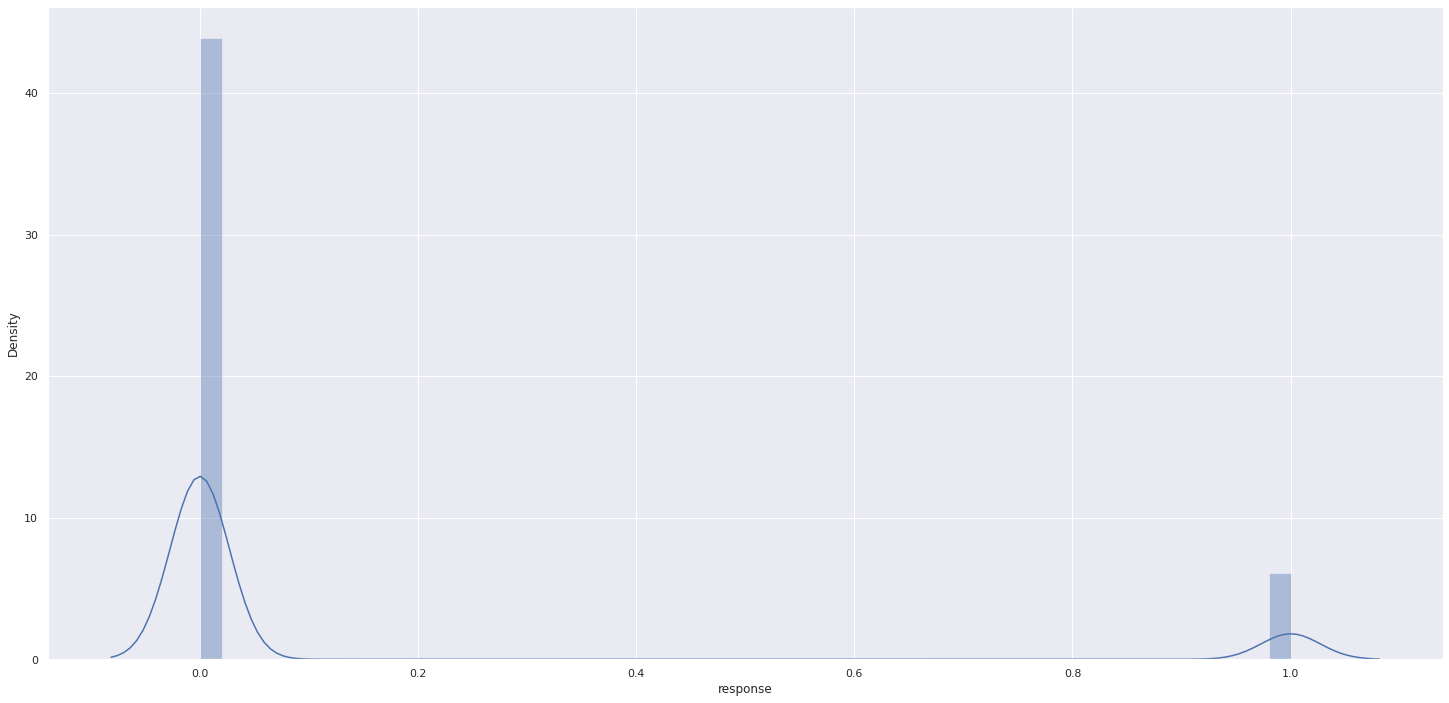

In [ ]:
# plot graphic - displot, etc..
sns.distplot(df4['response']);

### 4.1.2. Numerical Variable

#### 4.1.2.0 OVERVIEW

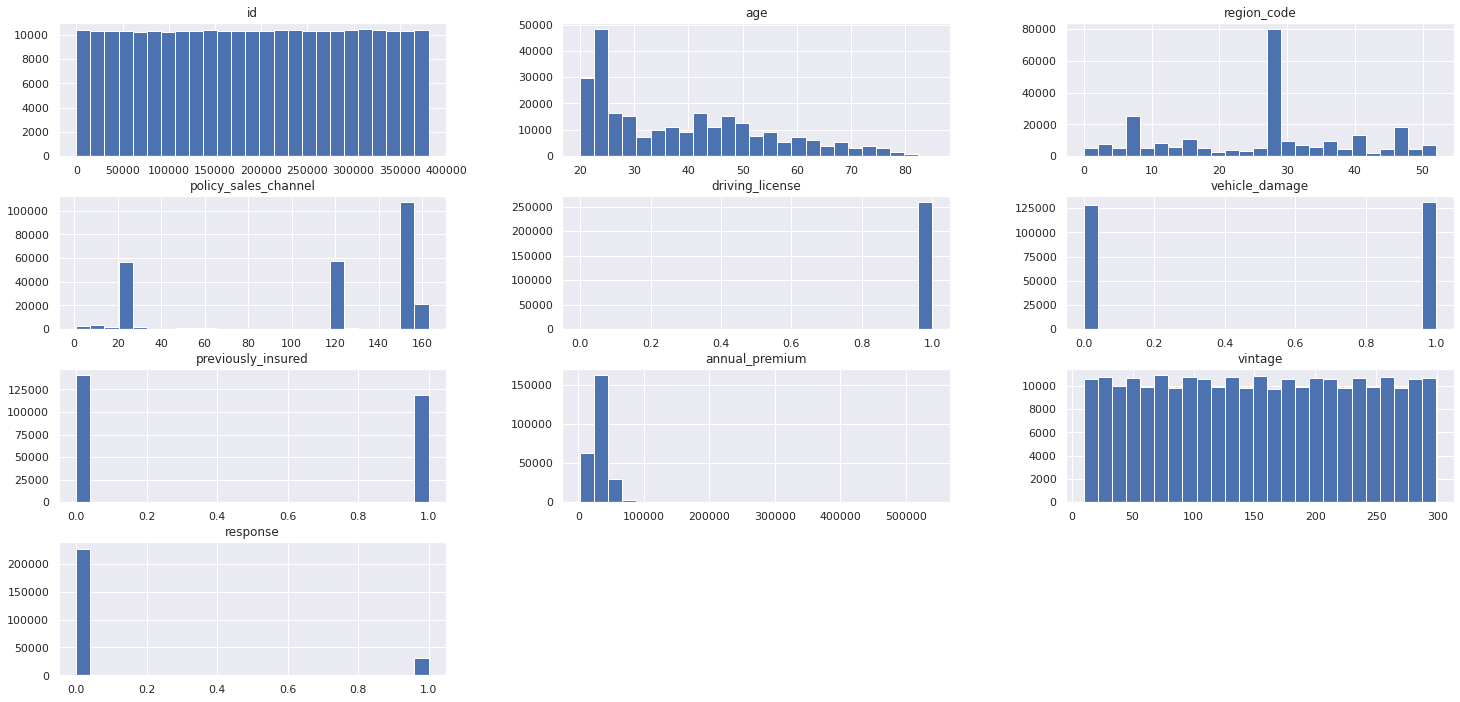

In [ ]:
# plot graphic num_attributes - hist, etc..
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
num_attributes.hist( bins=25 );

#### 4.1.2.1 Age

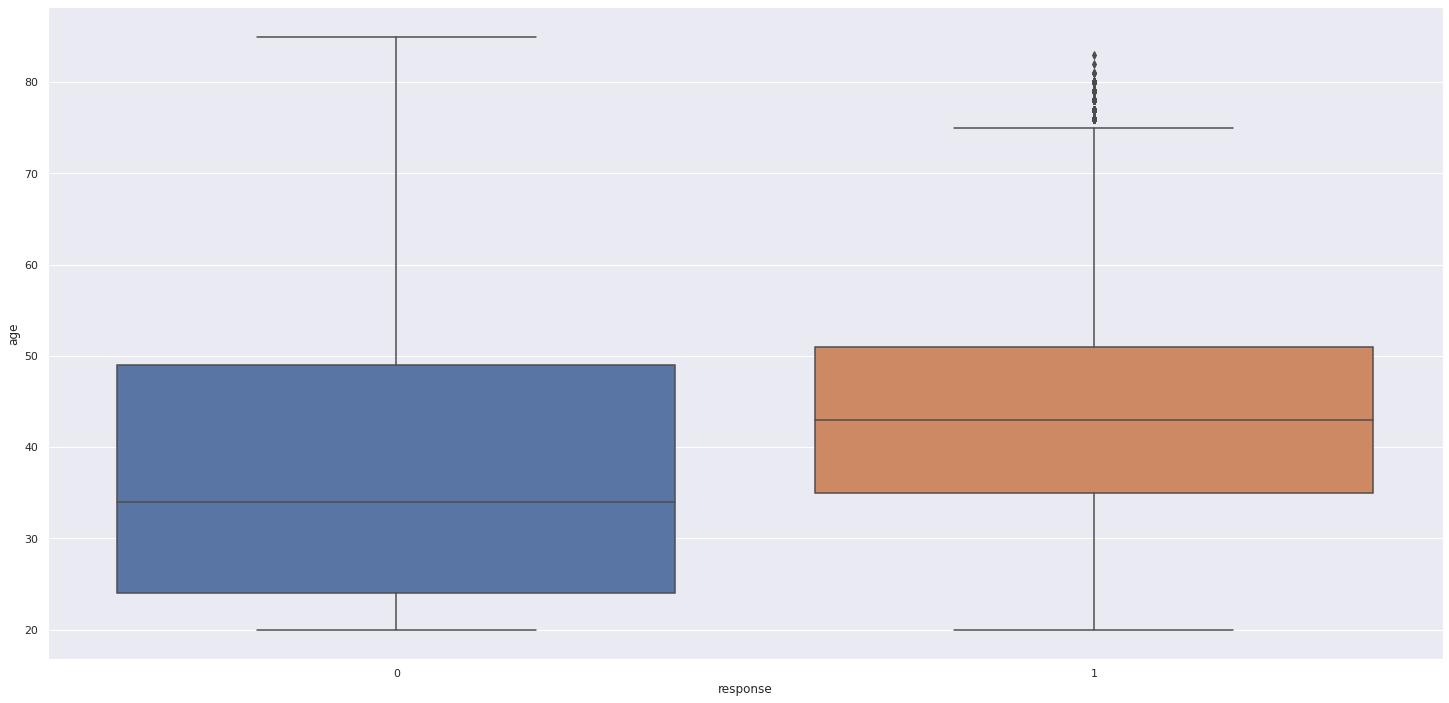

In [ ]:
sns.boxplot( x='response', y='age', data=df4 );

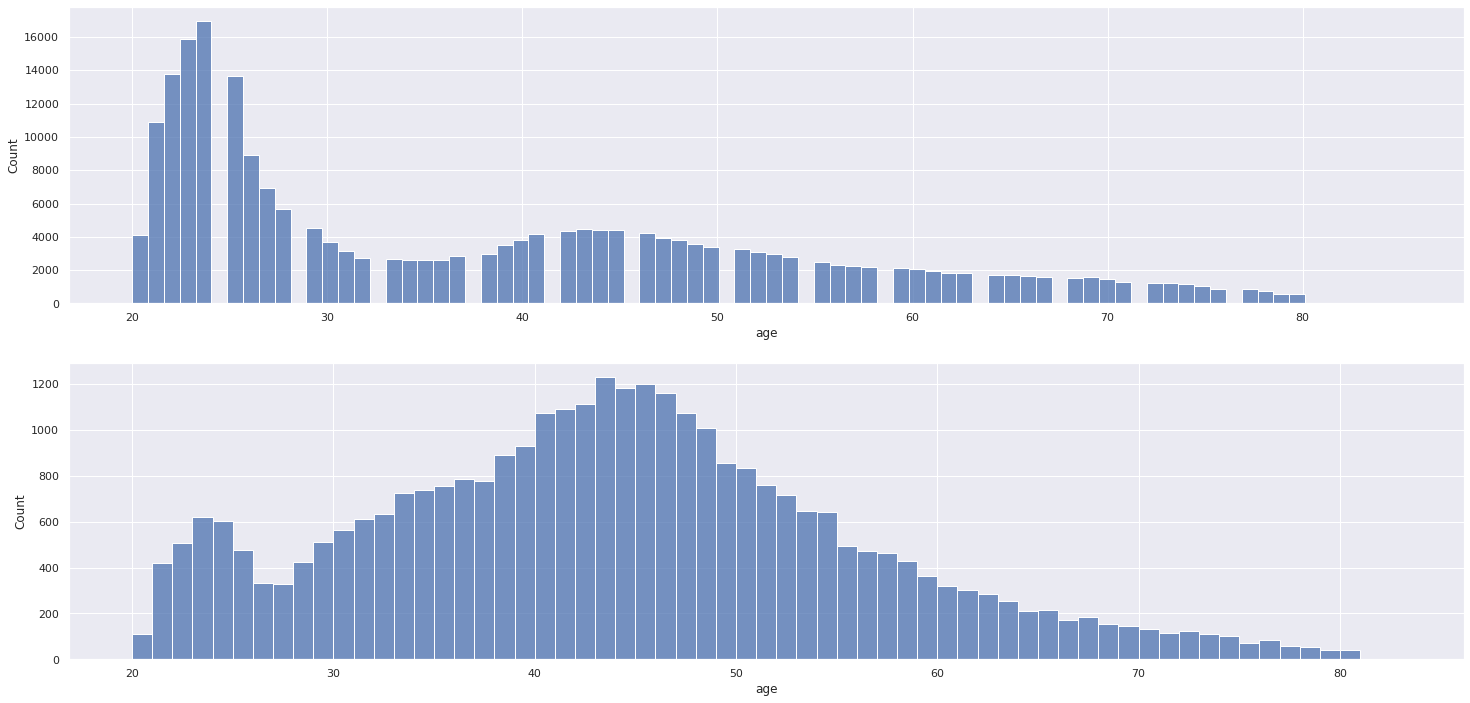

In [ ]:
aux00 = df4.loc[df4['response'] == 0, 'age']
plt.subplot( 2, 1, 1 )
sns.histplot( aux00 );

plt.subplot( 2, 1, 2 )
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 );

#### 4.1.2.2 Annual Premium

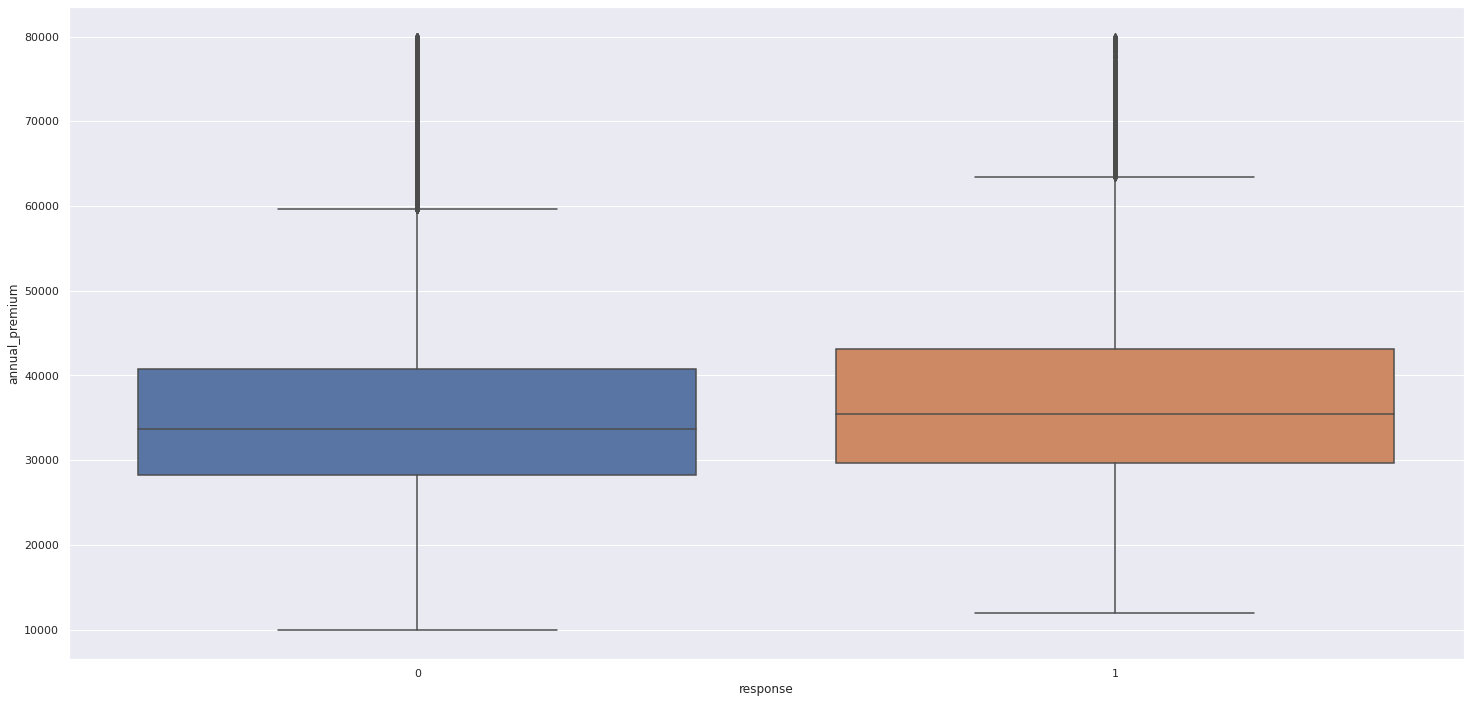

In [ ]:
aux1 = df4[( df4['annual_premium'] > 10000 ) & ( df4['annual_premium'] < 80000 )]
sns.boxplot( x = 'response', y = 'annual_premium', data = aux1 );

Response = 0 & Response = 1

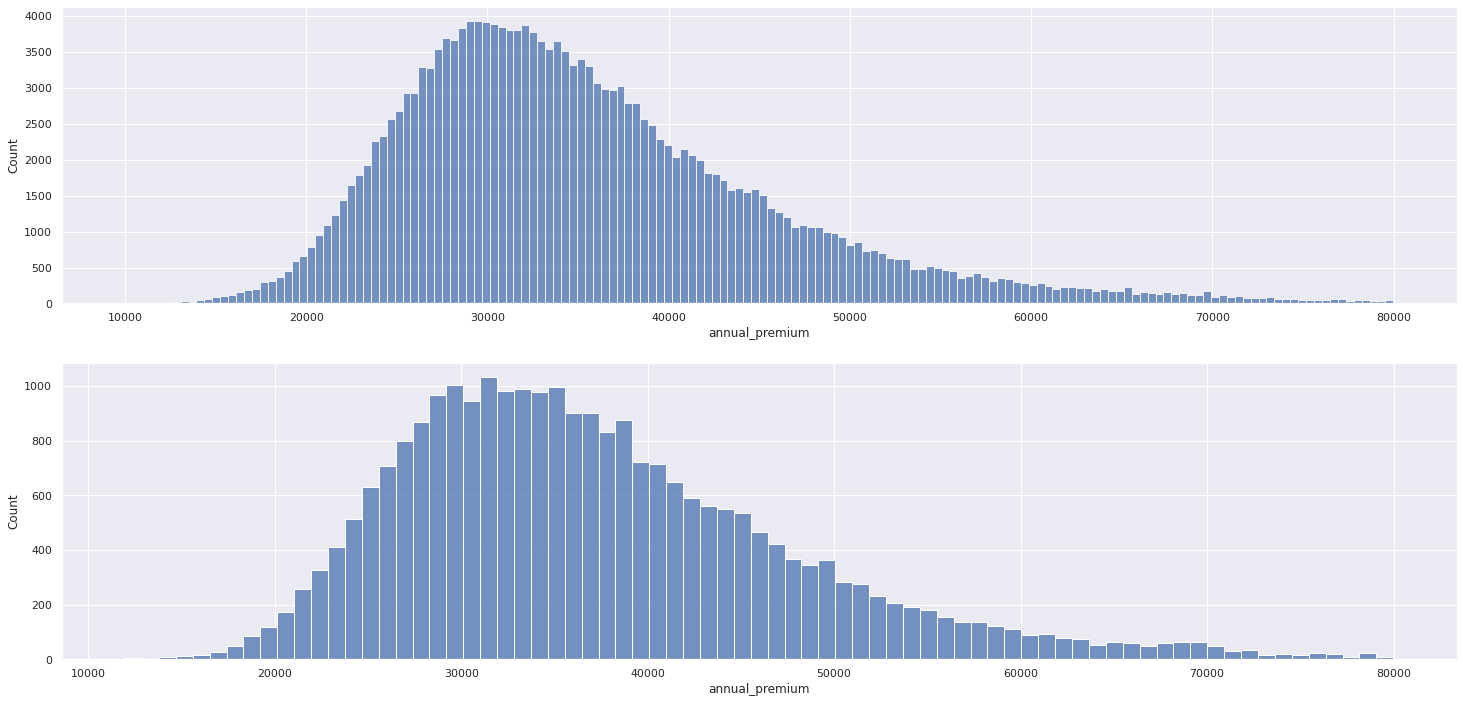

In [ ]:
aux00 = aux1.loc[df4['response'] == 0, 'annual_premium']
plt.subplot( 2, 1, 1 )
sns.histplot( aux00 );

plt.subplot( 2, 1, 2 )
aux00 = aux1.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

#### 4.1.2.3 Driving License


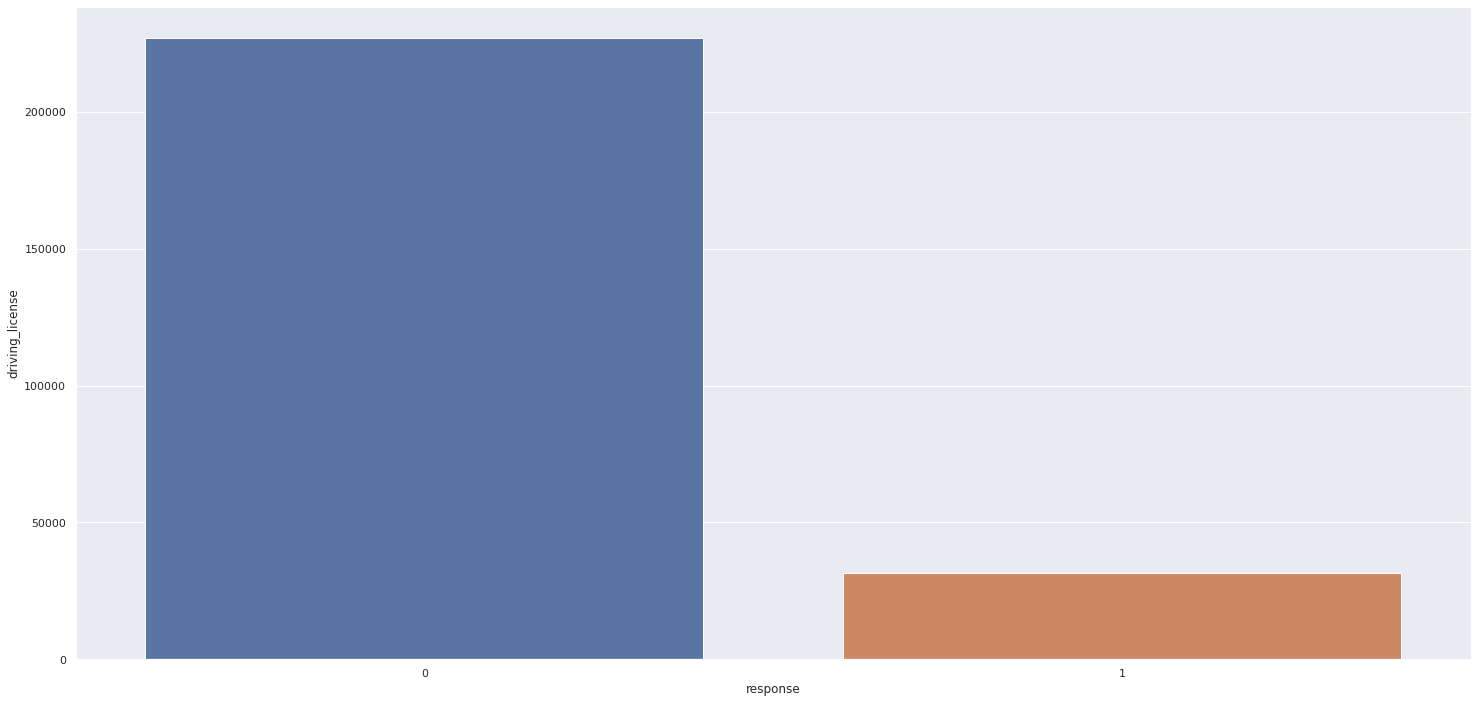

In [ ]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_lic'] = aux['driving_license'] / aux['driving_license'].sum()
# aux.head()
sns.barplot(x='response', y='driving_license', data=aux)

#### 4.1.2.4 Region Code


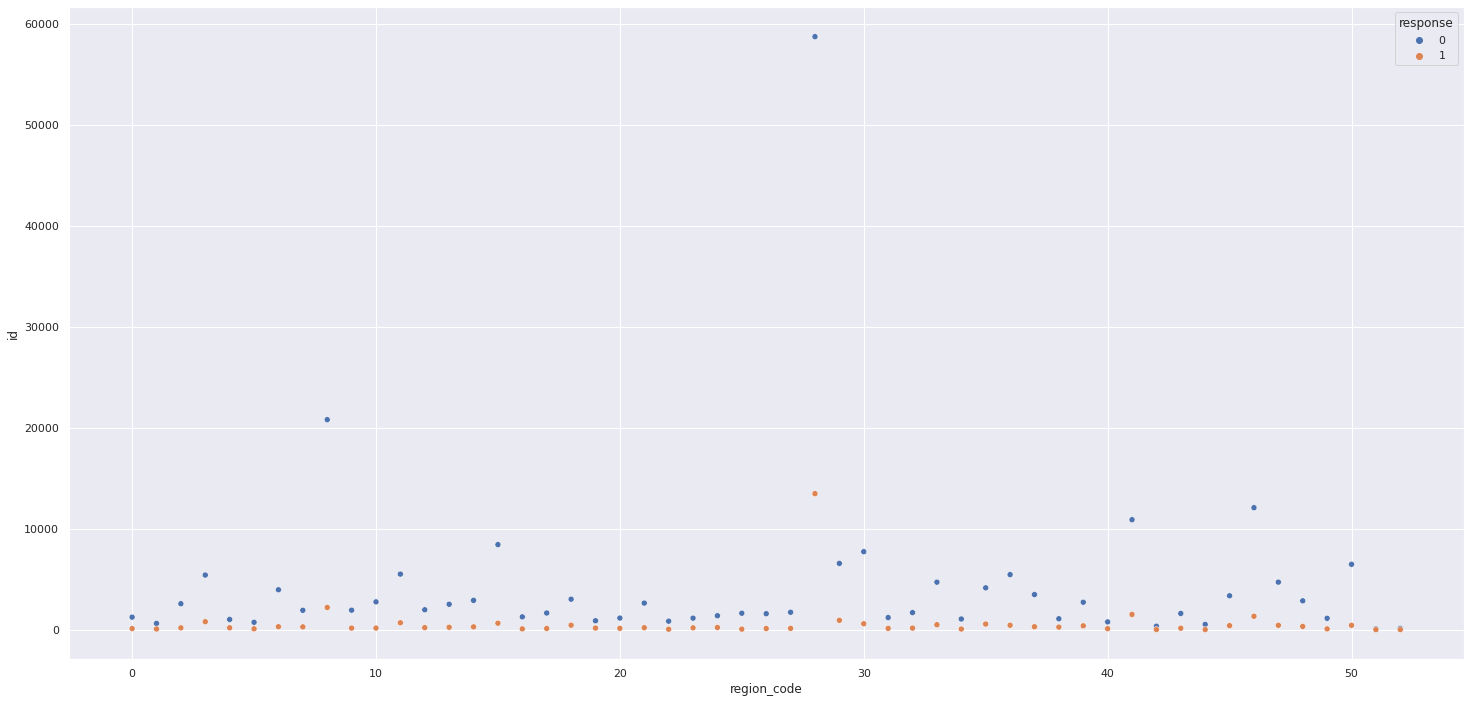

In [ ]:
ax0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=ax0);

#### 4.1.2.5 Previously insured


In [ ]:
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.7752,0.2248
1,0.9991,0.0009


#### 4.1.2.6 Vehicle Age


In [ ]:
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_years,0,0.4340
1,below_1_year,0,0.4137
2,between_1_2_years,1,0.0911
3,over_2_years,0,0.0300
4,below_1_year,1,0.0190
5,over_2_years,1,0.0122


#### 4.1.2.7 Policy Sales Channel


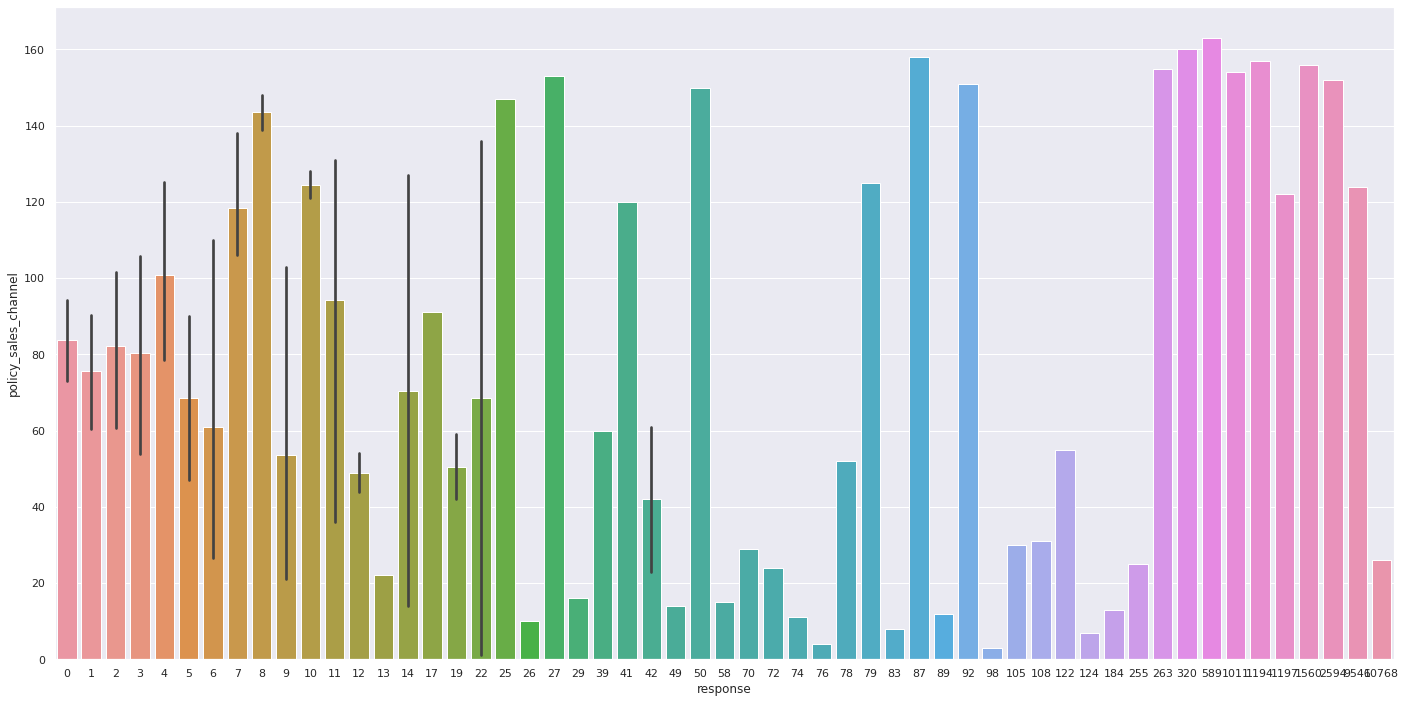

In [ ]:
plt.figure( figsize=(24,12) )
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

#### 4.1.2.8 Vintage

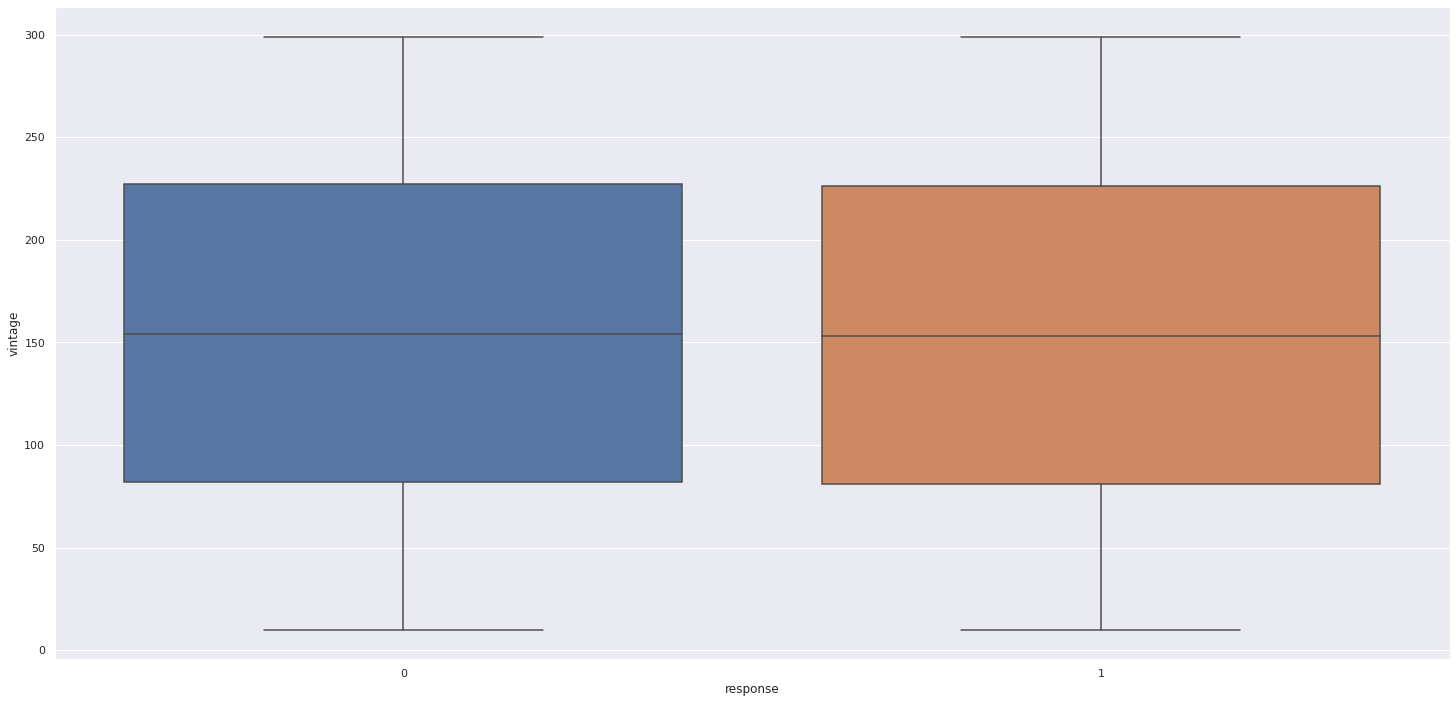

In [ ]:
sns.boxplot( x='response', y='vintage', data=df4 );

Response = 0 & Response = 1

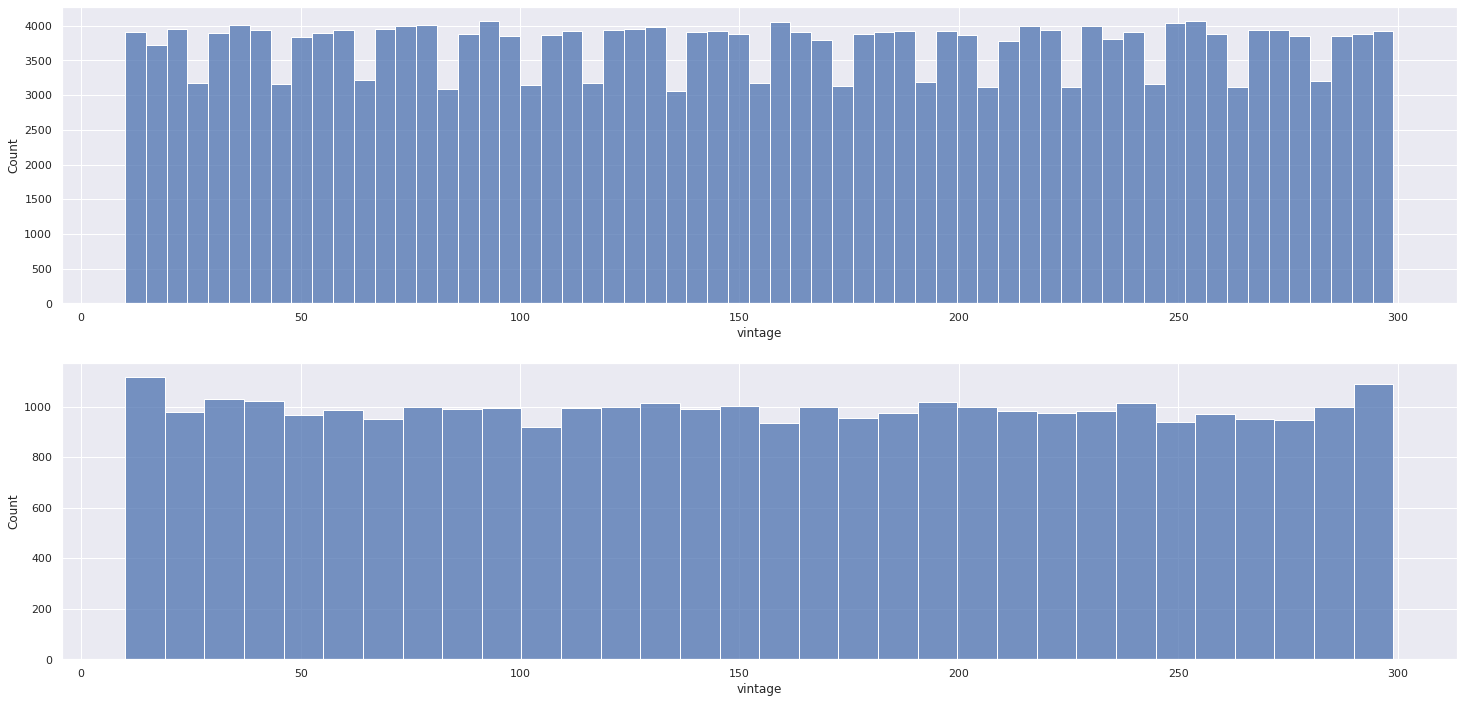

In [ ]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
plt.subplot( 2, 1, 1 )
sns.histplot( aux00 );

plt.subplot( 2, 1, 2 )
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux00 );

### <s>4.1.3. Categorical Variable</s>

## 4.2. Analise Bivariada

### 1. Pessoas que tem annual_premium >= 30564 (MEAN) tem mais interesse

**VERDADEIRA** Cerca de (58.34%) das pessoas interessadas são as pessoas que tem (annual_premium >= 30564)

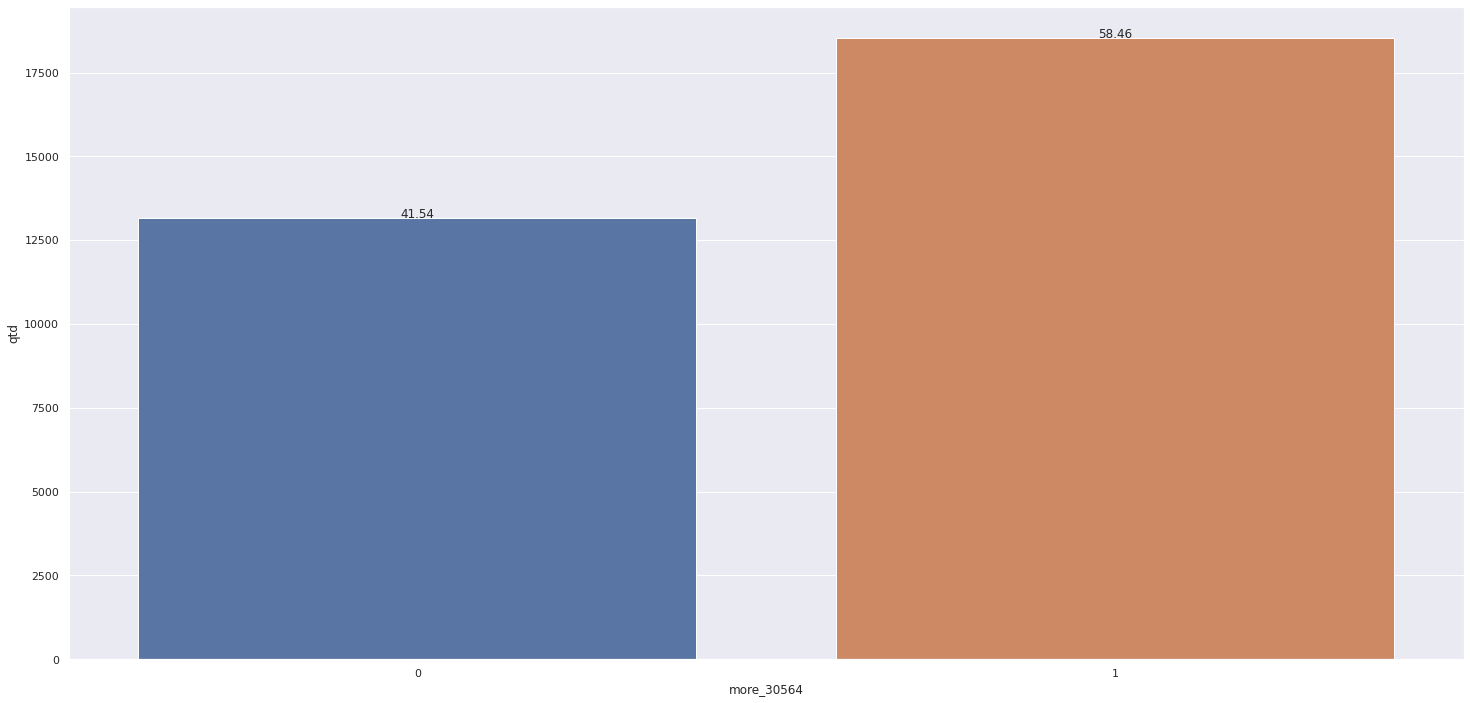

In [ ]:
aux = df4.copy()
aux['more_30564'] = df4['annual_premium'].apply(lambda x: 0 if x<30564 else 1)
aux1 = aux[aux['response'] == 1]

aux1 = aux1[['more_30564']].groupby( 'more_30564' ).size().reset_index().rename(columns={0:'qtd'})
ax1 = sns.barplot( x='more_30564', y='qtd', data=aux1 )

total = sum(aux1['qtd'])
graphic_percentage( ax1, total )

### 2. Pessoas com age >= 49 (Q3) tem menos interesse para a oferta

**VERDADEIRA** Cerca de (68.98%) das pessoas interessadas são as pessoas que tem menos de 49 anos.

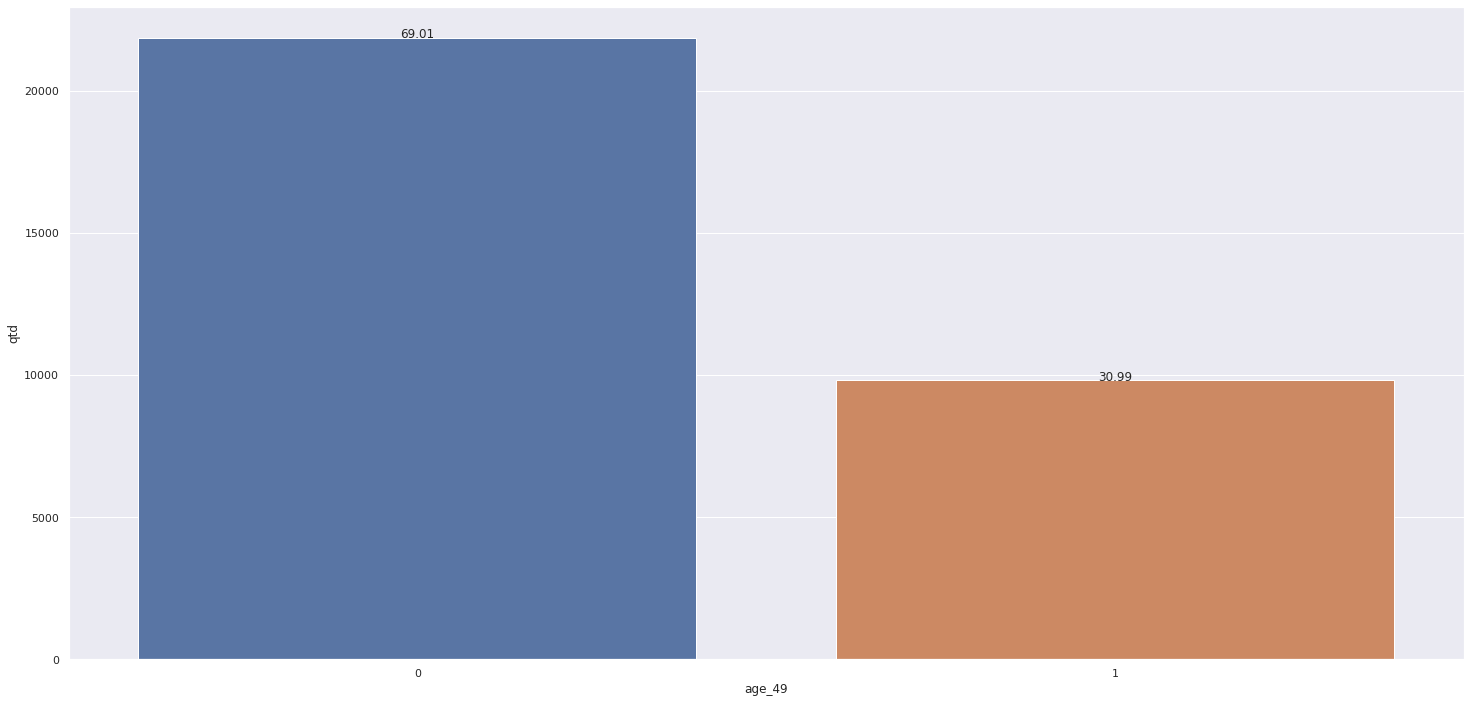

In [ ]:
aux = df4.copy()
aux['age_49'] = df4['age'].apply(lambda x: 0 if x<49 else 1)
aux1 = aux[aux['response'] == 1]

aux1 = aux1[['age_49']].groupby( 'age_49' ).size().reset_index().rename(columns={0:'qtd'})
ax1 = sns.barplot( x='age_49', y='qtd', data=aux1 )

total = sum(aux1['qtd'])
graphic_percentage( ax1, total )

### 3. Pessoas com vintage >= 227 (Q3) tem mais interesse para a oferta

**FALSA** Cerca de (74.92%) das pessoas interessadas são as pessoas que tem (vintage < 227) de 49 anos.

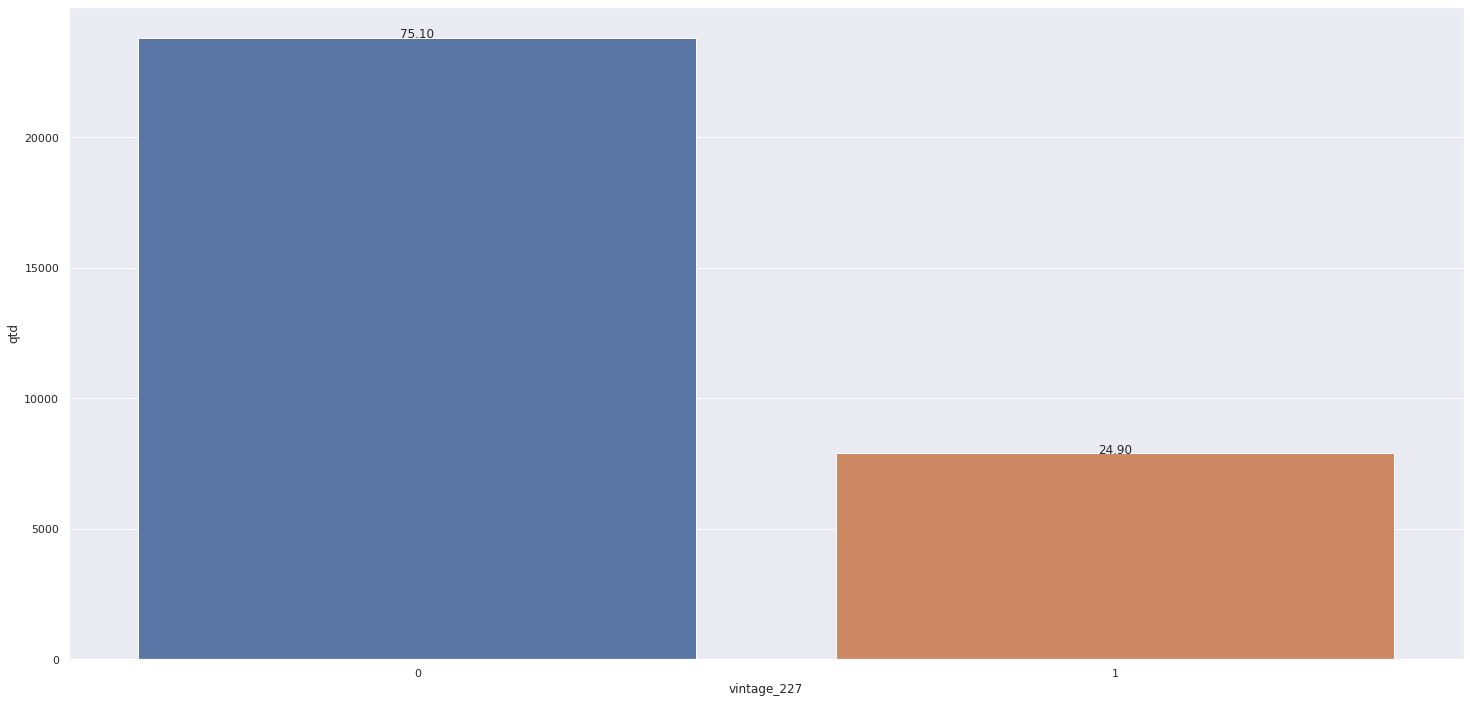

In [ ]:
aux = df4.copy()
aux['vintage_227'] = df4['vintage'].apply(lambda x: 0 if x<227 else 1)
aux1 = aux[aux['response'] == 1]

aux1 = aux1[['vintage_227']].groupby( 'vintage_227' ).size().reset_index().rename(columns={0:'qtd'})
ax1 = sns.barplot( x='vintage_227', y='qtd', data=aux1 )

total = sum(aux1['qtd'])
graphic_percentage( ax1, total )

### 4. Pessoas com driving_license == 0 (MIN) tem menos interesse para a oferta
**VERDADEIRA** Cerca de (0.10%) das pessoas interessadas não tem driving license

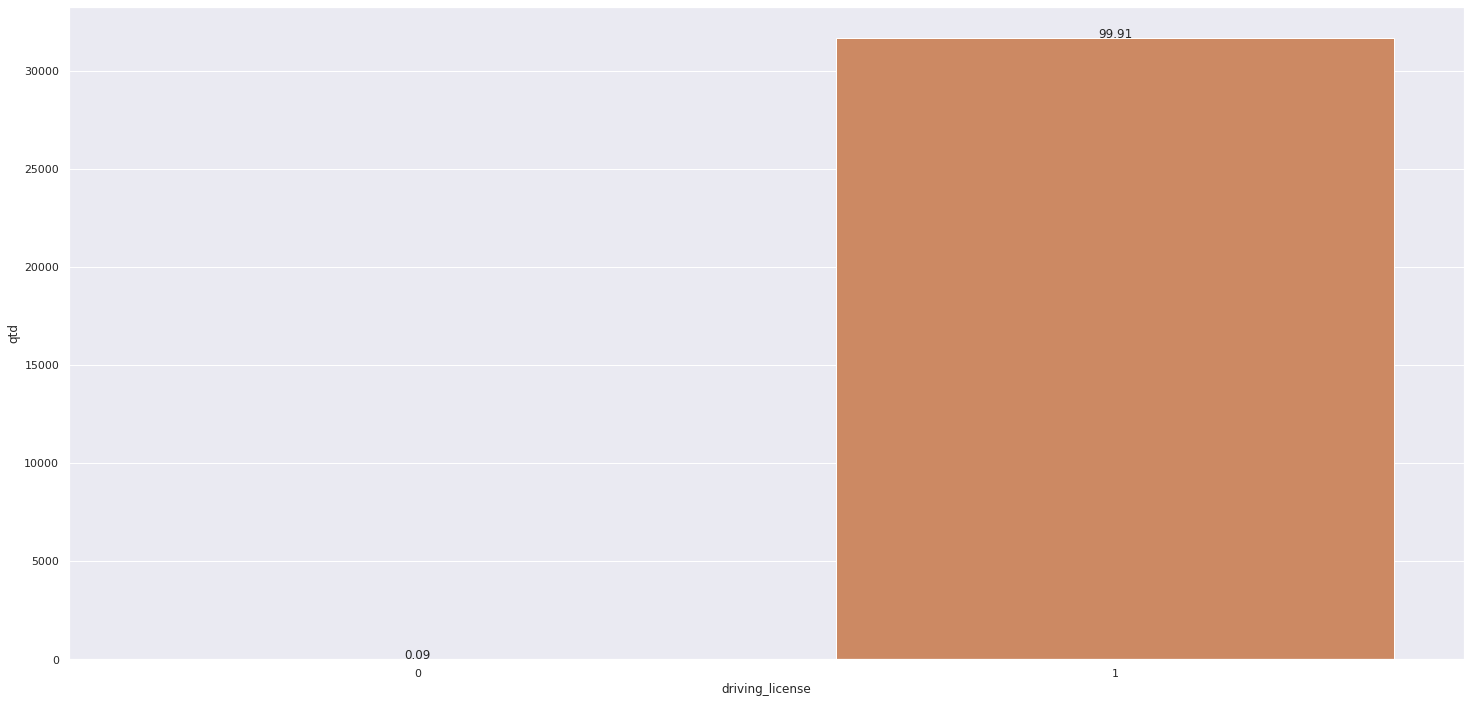

In [ ]:
aux = df4.copy()
aux1 = aux[aux['response'] == 1]

aux1 = aux1[['driving_license']].groupby( 'driving_license' ).size().reset_index().rename(columns={0:'qtd'})
ax1 = sns.barplot( x='driving_license', y='qtd', data=aux1 )

total = sum(aux1['qtd'])
graphic_percentage( ax1, total )

### 5. Pessoas com previously_insured == 0 (MIN) tem mais interesse para a oferta
**VERDADEIRA** Cerca de (99.67%) das pessoas interessadas não tem previously insured

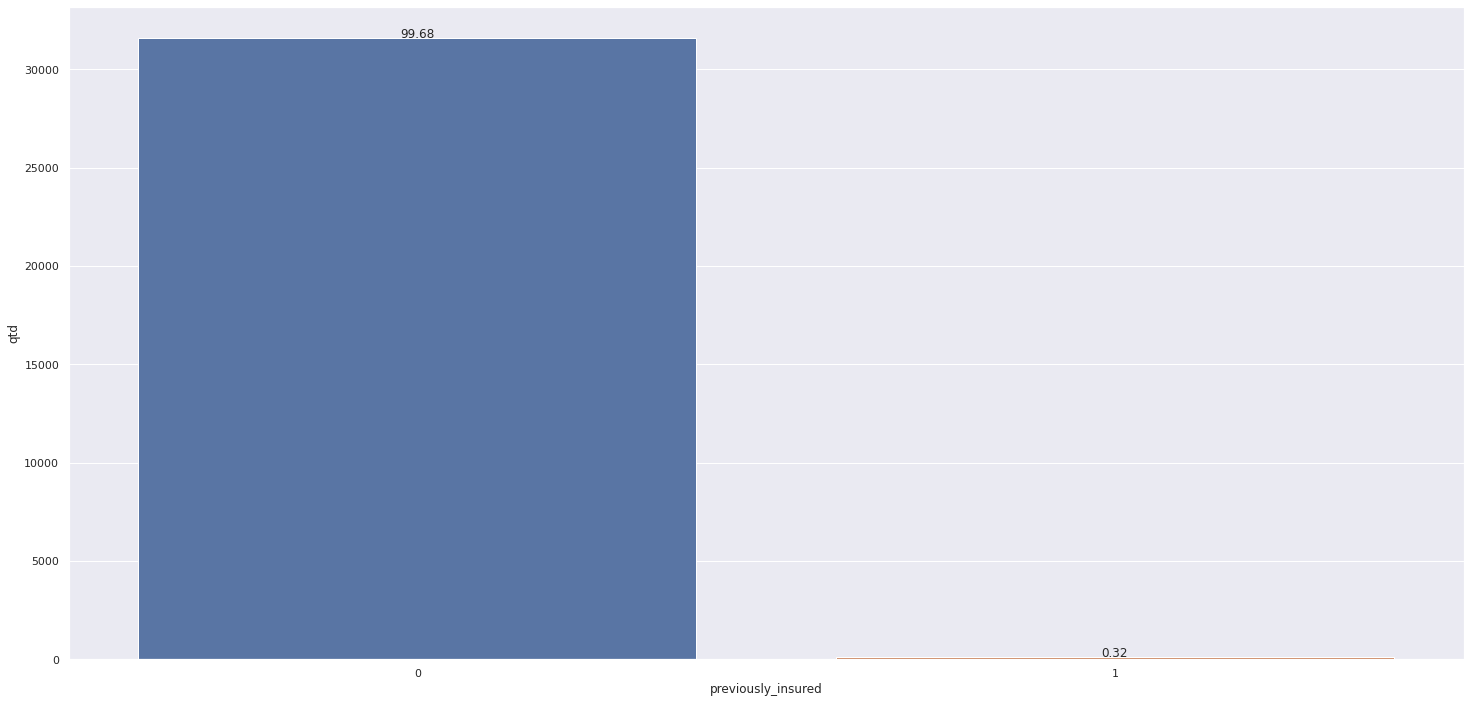

In [ ]:
aux = df4.copy()
aux1 = aux[aux['response'] == 1]

aux1 = aux1[['previously_insured']].groupby( 'previously_insured' ).size().reset_index().rename(columns={0:'qtd'})
ax1 = sns.barplot( x='previously_insured', y='qtd', data=aux1 )

total = sum(aux1['qtd'])
graphic_percentage( ax1, total )

### 6. Pessoas com gender == 'Female' tem menos interesse para a oferta

**VERDADEIRA** Mulheres tem em média (39%) de interesse enquanto Homens tem em média (61%) de interesse

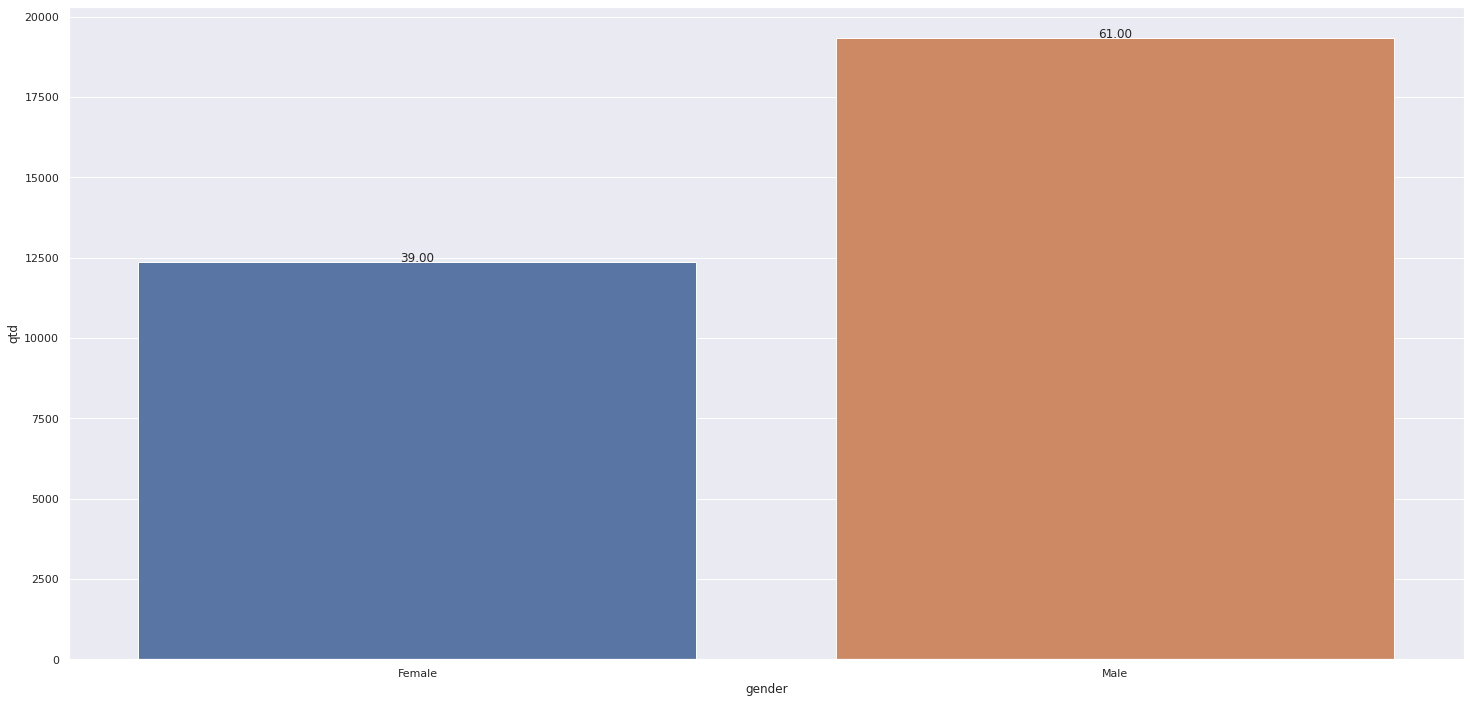

In [ ]:
aux = df4.copy()
aux1 = aux[aux['response'] == 1]

aux1 = aux1[['gender']].groupby( 'gender' ).size().reset_index().rename(columns={0:'qtd'})
ax1 = sns.barplot( x='gender', y='qtd', data=aux1 )

total = sum(aux1['qtd'])
graphic_percentage( ax1, total )

### 7. Pessoas com vehicle_damage == 0 (MIN) tem menos interesse para a oferta

**VERDADEIRA** Cerca de (97.97%) das pessoas interessadas já tiveram danos ao seus veículos

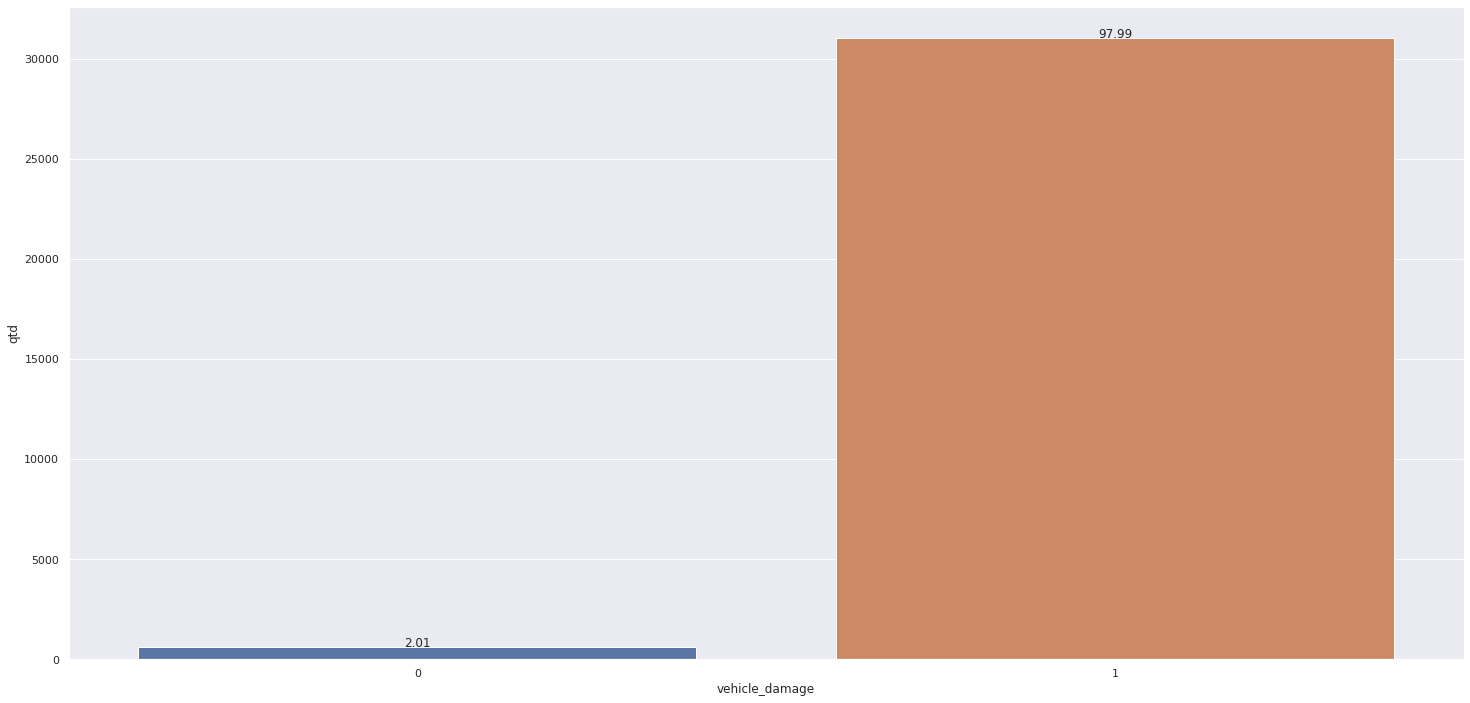

In [ ]:
aux = df4.copy()
aux1 = aux[aux['response'] == 1]

aux1 = aux1[['vehicle_damage']].groupby( 'vehicle_damage' ).size().reset_index().rename(columns={0:'qtd'})
ax1 = sns.barplot( x='vehicle_damage', y='qtd', data=aux1 )

total = sum(aux1['qtd'])
graphic_percentage( ax1, total )

## Resumo das Hipóteses

In [ ]:
tab = [['Hipoteses', 'Conclusao', 'Relevância'],
      ['H1', 'verdadeira', 'media'],
      ['H2', 'verdadeira', 'media'],
      ['H3', 'falsa', 'baixa'],
      ['H4', 'verdadeira', 'alta'],
      ['H5', 'verdadeira', 'alta'],
      ['H6', 'verdadeira', 'media'],
      ['H7', 'verdadeira', 'alta']]

print( tabulate( tab, headers='firstrow'))

Hipoteses    Conclusao    Relevância
-----------  -----------  ------------
H1           verdadeira   media
H2           verdadeira   media
H3           falsa        baixa
H4           verdadeira   alta
H5           verdadeira   alta
H6           verdadeira   media
H7           verdadeira   alta


## 4.3. Analise Multivariada

### 4.3.1 Numerical Attributes

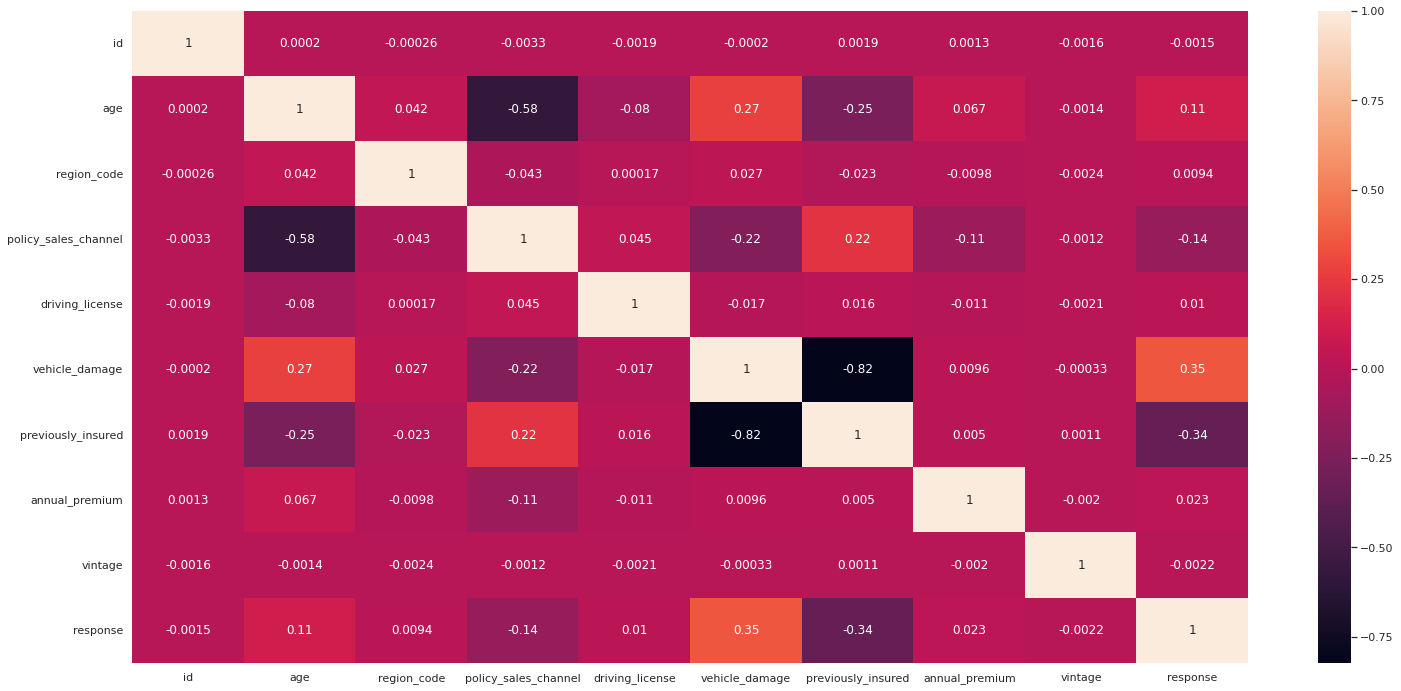

In [ ]:
correlation = num_attributes.corr( method='pearson')
sns.heatmap(correlation, annot=True )

### 4.3.2 Categorical Attributes

In [ ]:
a = df4.select_dtypes( include='object' ).copy()
a['female'] = df4['gender'].apply( lambda x: 1 if x == 'Female' else 0 )
a['male'] = df4['gender'].apply( lambda x: 1 if x == 'Male' else 0 )

a['below_1_year'] = df4['vehicle_age'].apply( lambda x: 1 if x == 'below_1_year' else 0 )
a['between_1_2_years'] = df4['vehicle_age'].apply( lambda x: 1 if x == 'between_1_2_years' else 0 )
a['over_2_years'] = df4['vehicle_age'].apply( lambda x: 1 if x == 'over_2_years' else 0 )

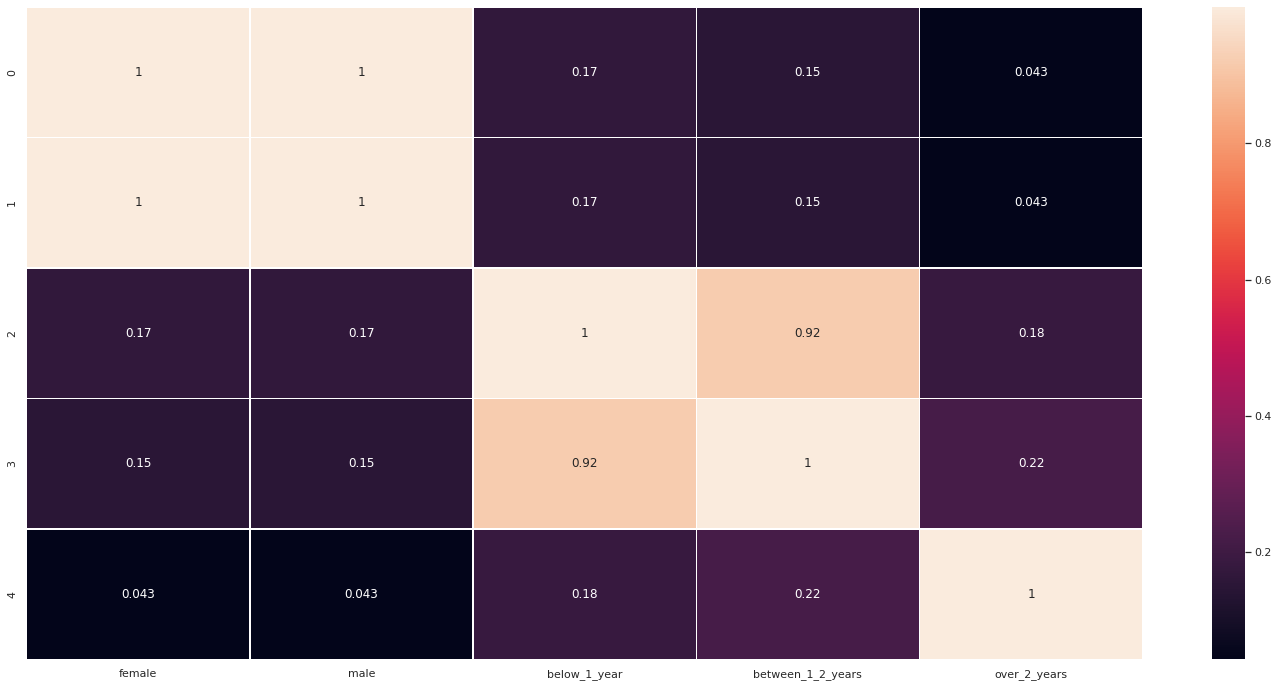

In [ ]:
a1 = cramer_v(a['female'], a['female'])
a2 = cramer_v(a['female'], a['male'])
a3 = cramer_v(a['female'], a['below_1_year'])
a4 = cramer_v(a['female'], a['between_1_2_years'])
a5 = cramer_v(a['female'], a['over_2_years'])

a6 = cramer_v(a['male'], a['female'])
a7 = cramer_v(a['male'], a['male'])
a8 = cramer_v(a['male'], a['below_1_year'])
a9 = cramer_v(a['male'], a['between_1_2_years'])
a10 = cramer_v(a['male'], a['over_2_years'])

a11 = cramer_v(a['below_1_year'], a['female'])
a12 = cramer_v(a['below_1_year'], a['male'])
a13 = cramer_v(a['below_1_year'], a['below_1_year'])
a14 = cramer_v(a['below_1_year'], a['between_1_2_years'])
a15 = cramer_v(a['below_1_year'], a['over_2_years'])

a16 = cramer_v(a['between_1_2_years'], a['female'])
a17 = cramer_v(a['between_1_2_years'], a['male'])
a18 = cramer_v(a['between_1_2_years'], a['below_1_year'])
a19 = cramer_v(a['between_1_2_years'], a['between_1_2_years'])
a20 = cramer_v(a['between_1_2_years'], a['over_2_years'])

a21 = cramer_v(a['over_2_years'], a['female'])
a22 = cramer_v(a['over_2_years'], a['male'])
a23 = cramer_v(a['over_2_years'], a['below_1_year'])
a24 = cramer_v(a['over_2_years'], a['between_1_2_years'])
a25 = cramer_v(a['over_2_years'], a['over_2_years'])

d = pd.DataFrame( {'female': [a1, a2, a3, a4, a5],
                   'male': [a6, a7, a8, a9, a10],
                   'below_1_year': [a11, a12, a13, a14, a15],
                   'between_1_2_years': [a16, a17, a18, a19, a20],
                   'over_2_years': [a21, a22, a23, a24, a25]})
d.set_index( d.columns )

sns.heatmap( d, annot=True, linewidths=.5)

## 4.4. Hipothesis Insights

**<u>KEEP AN EYE</u>**

Através das análises gráficas das hipóteses podemos observar que as features que parecem ter importância são:

1) **driving_license**

2) **previously_insured**

3) **vehicle_damage**

4) **age**

5) **gender**

6) **vehicle_age**

<s>7) **region_code</s>**

Como faltam explicações mais claras para origem de **region_code**, devemos ficar de olho futuramente sobre essa feature

Nos próximos passos, devemos analisar mais a fundo com auxilio de um algoritmo para poder calcular o quão relevante essas features podem ser para o meu modelo.



# 5.0. PASSO 05 - DATA PREPARATION

In [ ]:
df5 = df4.copy()

In [ ]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
39409,314060,Female,47,28,122,1,between_1_2_years,1,0,43073,74,0
145721,22323,Female,49,28,26,1,between_1_2_years,1,0,48826,153,1
104798,73857,Female,57,39,124,1,between_1_2_years,1,0,45922,47,0
32204,257105,Male,40,28,124,1,over_2_years,1,0,36616,33,1
109245,110127,Male,56,15,152,1,between_1_2_years,0,1,27986,228,0


## 5.1 Standardization

In [ ]:
# Subtrai da média e divide pelo desvio padrão
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )

## 5.2 Rescaling

In [ ]:
# Reescala dos intervalos entre [0,1] - como não é distribuição normal
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df4[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df4[['vintage']].values )

## 5.3 Encoding

In [ ]:
# Muda o tipo da variável da categórica para numerica, respeitando a natureza da variável - entre 0 e 1 (sim ou nao)
# gender - Frequency Encoding / *Target Encoding / Weighted Target ENcoding
target_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_gender )

# region_code - Frequency Encoding / *Target Encoding / Weighted Target ENcoding
target_region = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_region )

# vehicle_age - *One Hot Encoding / Order Encoding / Frequency Encoding / Target Encoding / Weighted Target ENcoding
target_vehicle_age = df5.groupby( 'vehicle_age' )['response'].mean()
df5.loc[:, 'vehicle_age'] = df5['vehicle_age'].map( target_vehicle_age )

# policy_sales_channel - Target Encoding / *Frequency Encoding
fe_policy = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy )

## 5.4 Data Validation Preparation



In [ ]:
x_val = x_validation.copy()
y_val = y_validation.copy()

In [ ]:
x_val.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
149147,49303,Female,23,8,152,1,below_1_year,0,1,30300,235
244414,47593,Female,24,9,152,1,below_1_year,0,1,2630,250
85429,300544,Female,24,22,152,1,below_1_year,0,1,28473,117
18037,143997,Male,74,46,26,1,between_1_2_years,1,0,2630,143
159831,133519,Male,39,28,26,1,over_2_years,1,0,59934,156


In [ ]:
# gender;
x_val.loc[:, 'gender'] = x_val['gender'].map( target_gender );

# age
x_val['age'] = mms_age.fit_transform( x_val[['age']].values );

# annual_premium
x_val['annual_premium'] = ss.fit_transform( x_val[['annual_premium']].values );

# vintage
x_val['vintage'] = mms_vintage.fit_transform( x_val[['vintage']].values );

# region_code
x_val.loc[:, 'region_code'] = x_val['region_code'].map( target_region );

# vehicle_age
x_val.loc[:, 'vehicle_age'] = x_val['vehicle_age'].map( target_vehicle_age );

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map( fe_policy );

# fill na
x_val = x_val.fillna( 0 );

## 5.5 Data Test Preparation



In [ ]:
# gender;
x_test.loc[:, 'gender'] = x_test['gender'].map( target_gender );

# age
x_test['age'] = mms_age.fit_transform( x_test[['age']].values );

# annual_premium
x_test['annual_premium'] = ss.fit_transform( x_test[['annual_premium']].values );

# vintage
x_test['vintage'] = mms_vintage.fit_transform( x_test[['vintage']].values );

# region_code
x_test.loc[:, 'region_code'] = x_test['region_code'].map( target_region );

# vehicle_age
x_test.loc[:, 'vehicle_age'] = x_test['vehicle_age'].map( target_vehicle_age );

# policy_sales_channel
x_test.loc[:, 'policy_sales_channel'] = x_test['policy_sales_channel'].map( fe_policy );

# fill na
x_test = x_test.fillna( 0 );

# 6.0. PASSO 06 - FEATURE SELECTION

In [ ]:
df6 = df5.copy()

In [ ]:
x_train = df6.drop( 'response', axis=1 )
y_train = df6['response']

## 6.1 Feature Importance

In [ ]:
# featuring importance
x_train_n = x_train.drop( 'id', axis=1 ).copy()
y_train_n = y_train.copy()

# define RandomForestClassifier
model = RandomForestClassifier()

# fit the model
model.fit(x_train_n, y_train_n)

RandomForestClassifier()

Feature: 0, Score: 0.01371
Feature: 1, Score: 0.14698
Feature: 2, Score: 0.09719
Feature: 3, Score: 0.06953
Feature: 4, Score: 0.00055
Feature: 5, Score: 0.01863
Feature: 6, Score: 0.07678
Feature: 7, Score: 0.04819
Feature: 8, Score: 0.24971
Feature: 9, Score: 0.27874


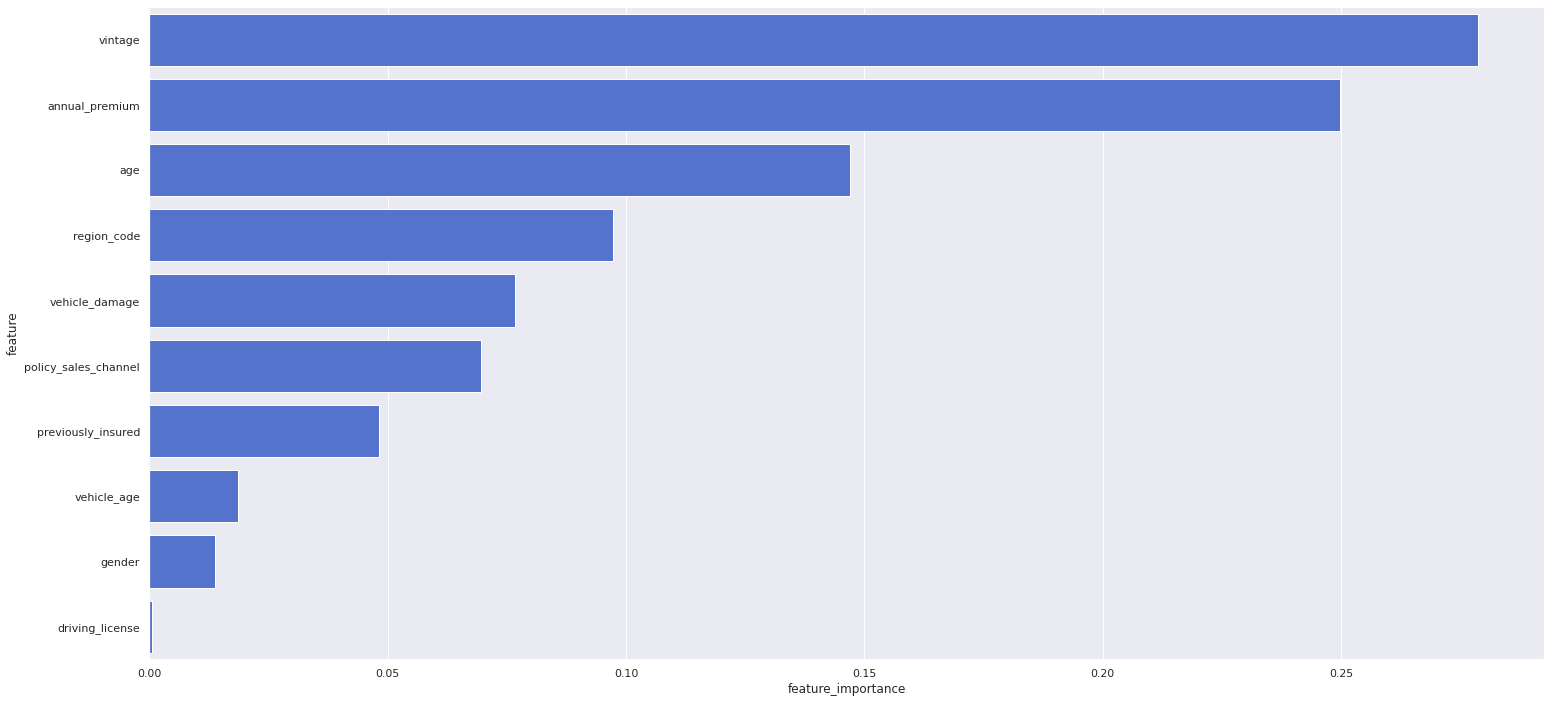

In [ ]:
# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
feat_imp = pd.DataFrame({'feature': x_train_n.columns,
                         'feature_importance': importance}).sort_values('feature_importance', ascending=False).reset_index(drop=True)

sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue');

### 6.1.1 Columns Selected

Here we could figure it out that there are **6 columns>** are relevant to our **model**, all above **0.05** of **feature_importance**.

In [ ]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']
cols_not_selected = ['vehicle_age', 'gender', 'driving_license']

In [ ]:
x_val.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
149147,49303,0.1039,0.0462,0.0962,0.3540,1,0.0439,0,1,-0.0193,0.7785
244414,47593,0.1039,0.0615,0.0812,0.3540,1,0.0439,0,1,-1.6010,0.8304
85429,300544,0.1039,0.0615,0.0654,0.3540,1,0.0439,0,1,-0.1237,0.3702
18037,143997,0.1380,0.8308,0.0999,0.2092,1,0.1735,1,0,-1.6010,0.4602
159831,133519,0.1380,0.2923,0.1867,0.2092,1,0.2893,1,0,1.6748,0.5052


# 7.0. PASSO 07 - MACHINE LEARNING MODELING

In [ ]:
df7 = df6.copy()

In [ ]:
x_train = x_train[cols_selected]
x_test = x_test[cols_selected]
x_val = x_val[cols_selected]

## 7.1 Comparing Models

In [ ]:
models_performance = pd.DataFrame()
models_list=[KNeighborsClassifier(n_jobs=-1),
             LogisticRegression(penalty='l2', solver='newton-cg'),
             GaussianNB(),
             LGBMClassifier(),
             xgb.XGBClassifier(objective='binary:logistic',
                               eval_metric='error',
                               n_estimators=100,
                               eta=0.01,
                               max_depth=10,
                               subsample=0.7,
                               colsample_bytree=0.9),
             RandomForestClassifier()]

models_performance = models_performance.append(models_train(models_list,x_train,y_train,x_val,y_val,'predict_proba','binaryClass',0))
models_performance

KNeighborsClassifier
LogisticRegression
GaussianNB
LGBMClassifier
XGBClassifier
RandomForestClassifier


,Index,Model,ROC AUC,Top K Score
0,0,KNeighborsClassifier,0.7531,0.8544
0,0,LogisticRegression,0.8160,0.8767
0,0,GaussianNB,0.8253,0.6394
0,0,LGBMClassifier,0.8530,0.8763
0,0,XGBClassifier,0.8519,0.8768
0,0,RandomForestClassifier,0.8305,0.8641


### 7.1.1 KNN Model

In [ ]:
# model prediction - Poder de GENERALIZACAO 
knn_model = models_list[0].fit( x_train, y_train )
yhat_knn = knn_model.predict_proba( x_val )

### 7.1.2 Logistic Regression Model

In [ ]:
# model prediction - Poder de GENERALIZACAO 
lr_model = models_list[1].fit( x_train, y_train )
yhat_lr = lr_model.predict_proba( x_val )

### 7.1.3 GaussianNB Model

In [ ]:
# model prediction - Poder de GENERALIZACAO 
gnb_model = models_list[2].fit( x_train, y_train )
yhat_gbn = gnb_model.predict_proba( x_val )

### 7.1.4 LGBM Model

In [ ]:
# model prediction - Poder de GENERALIZACAO 
lgbm_model = models_list[3].fit( x_train, y_train )
yhat_lgbm = lgbm_model.predict_proba( x_val )

### 7.1.5 XGB Model

In [ ]:
# model prediction - Poder de GENERALIZACAO 
xgb_model = models_list[4].fit( x_train, y_train )
yhat_xgb = xgb_model.predict_proba( x_val )

### 7.1.6 Random Forest Classifier

In [ ]:
# model prediction - Poder de GENERALIZACAO 
rf_model = models_list[5].fit( x_train, y_train )
yhat_rf = rf_model.predict_proba( x_val )

## 7.2 Comparing Cumulative Curve

### 7.2.1 K Nearest Neighbors

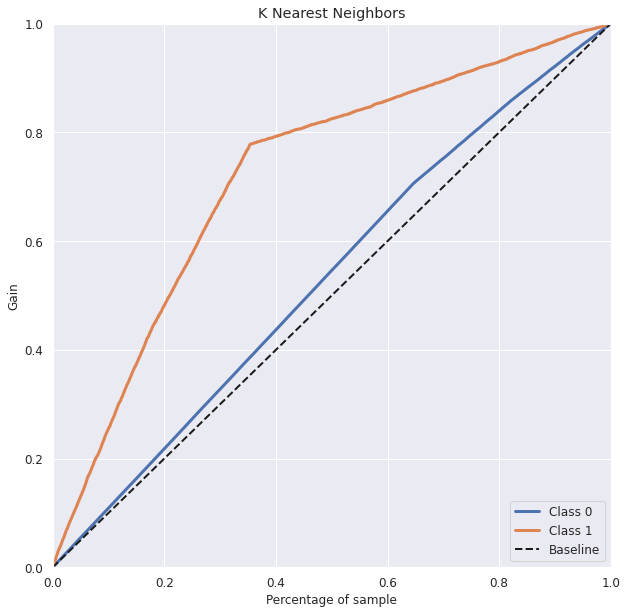

In [ ]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, figsize =(10, 10),title='K Nearest Neighbors' );

### 7.2.2 Logistic Regression

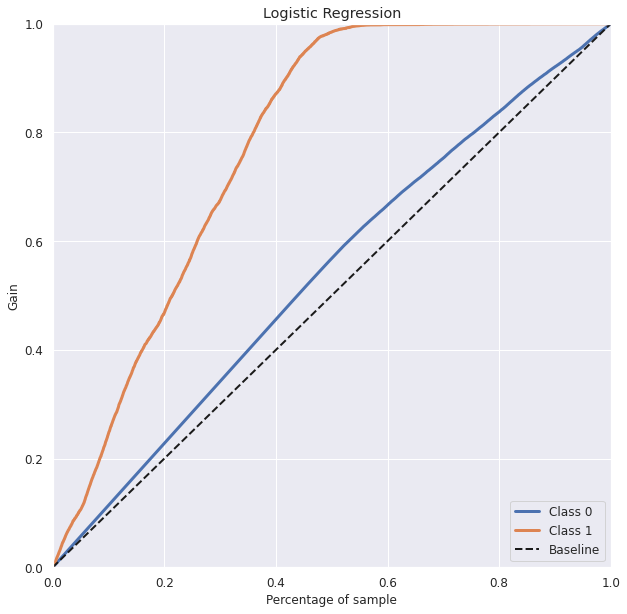

In [ ]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr, figsize =(10, 10),title='Logistic Regression' );

### 7.2.3 GaussianBN

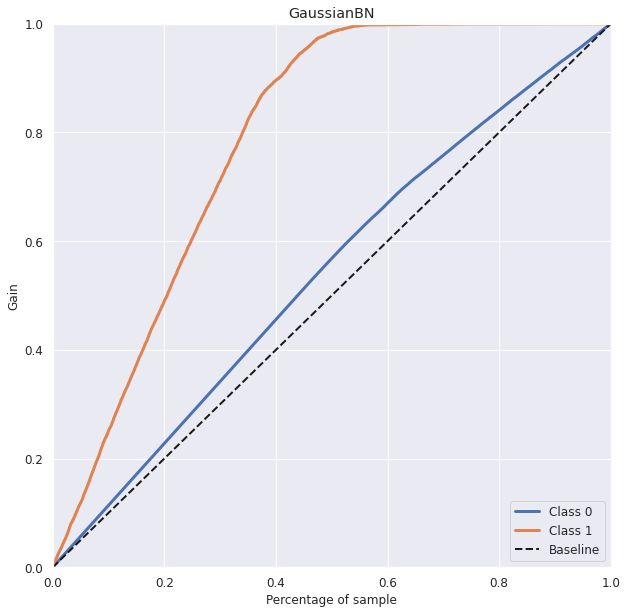

In [ ]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_gbn, figsize =(10, 10),title='GaussianBN' );

### 7.2.4 LightGBM

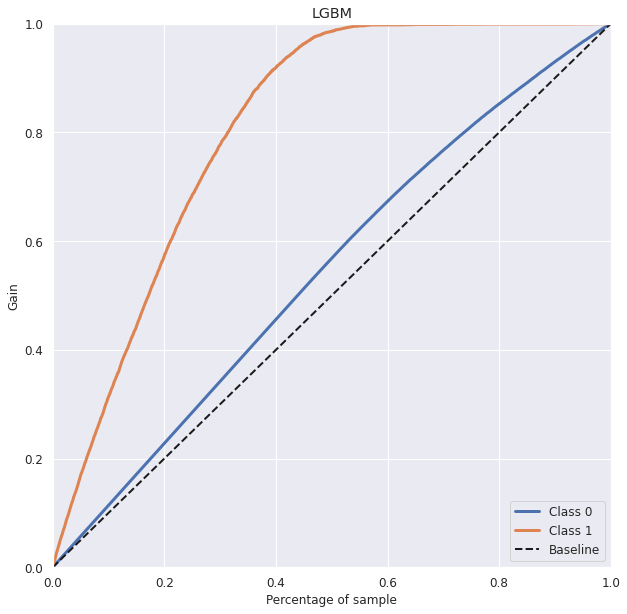

In [ ]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm, figsize =(10, 10),title='LGBM' );

### 7.2.5 XGBoost

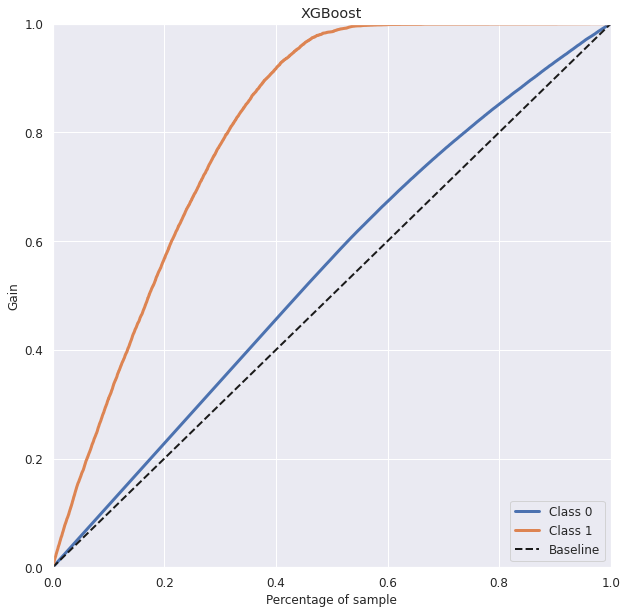

In [ ]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb, figsize =(10, 10),title='XGBoost' );

### 7.2.6 Random Forest Classifier

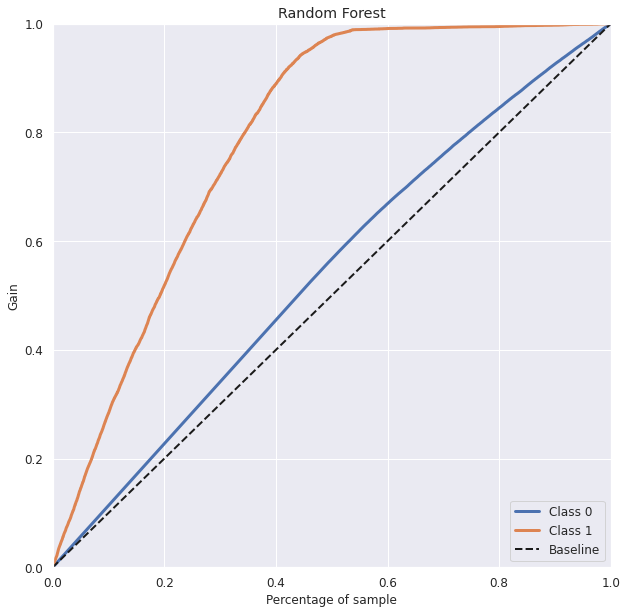

In [ ]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf, figsize =(10, 10),title='Random Forest' );

## 7.3 Comparing Lift Curve

### 7.3.1 K Nearest Neighbors

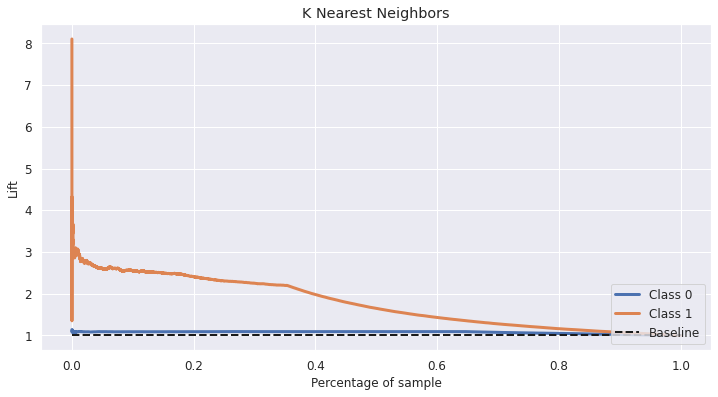

In [ ]:
skplt.metrics.plot_lift_curve( y_val, yhat_knn, figsize =(12,6),title='K Nearest Neighbors' );

### 7.3.2 Logistic Regression

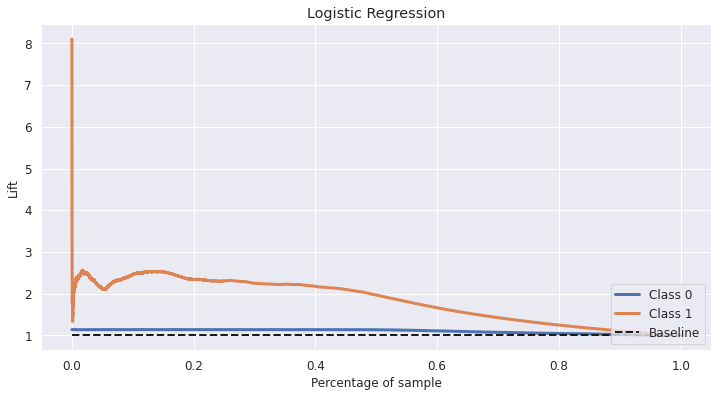

In [ ]:
skplt.metrics.plot_lift_curve( y_val, yhat_lr, figsize =(12,6),title='Logistic Regression' );

### 7.3.3 GaussianBN

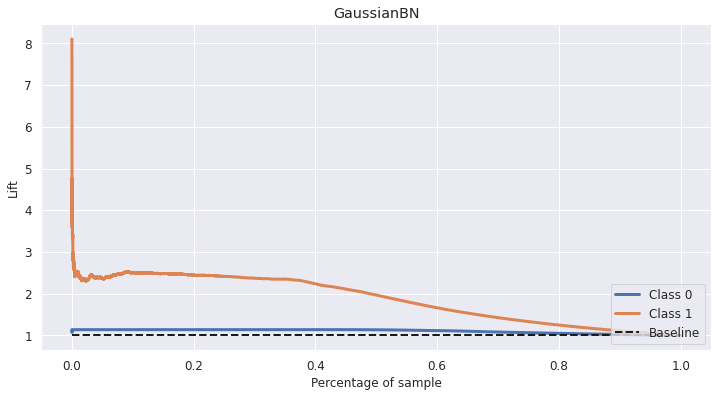

In [ ]:
skplt.metrics.plot_lift_curve( y_val, yhat_gbn, figsize =(12,6),title='GaussianBN' );

### 7.3.4 LightGBM

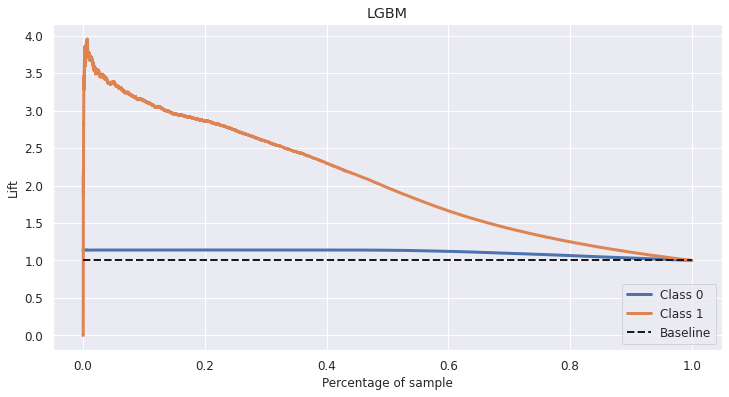

In [ ]:
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm, figsize =(12,6),title='LGBM' );

### 7.3.5 XGBoost

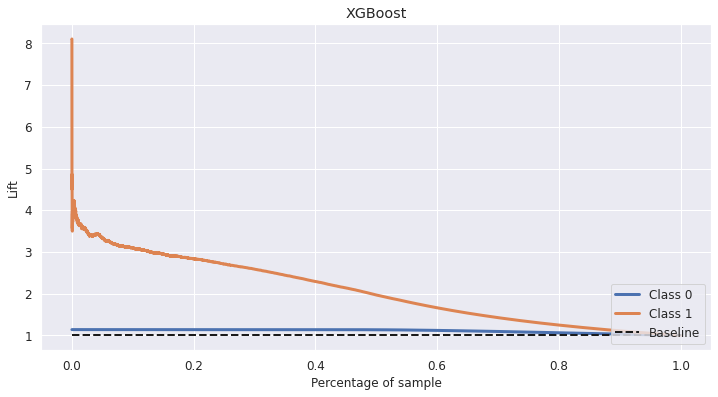

In [ ]:
skplt.metrics.plot_lift_curve( y_val, yhat_xgb, figsize =(12,6),title='XGBoost' );

### 7.3.6 Random Forest

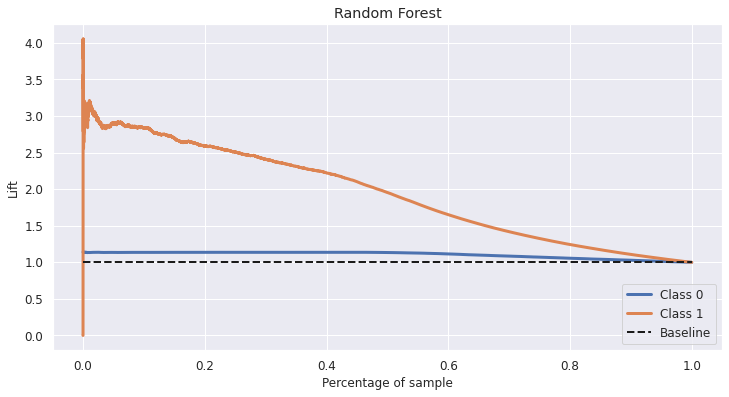

In [ ]:
skplt.metrics.plot_lift_curve( y_val, yhat_rf, figsize =(12,6),title='Random Forest' );

# 8.0. PASSO 08 - CROSS VALIDATION

In [ ]:
df8 = df7.copy()

## 8.1 K Nearest Neighbors

In [ ]:
models_performance = models_performance.append( cross_validation( 5, 'KNeighborsClassifier', knn_model, x_train, y_train, ranking_class_metrics ) )

KFold Number 1/5
KFold Number 2/5
KFold Number 3/5
KFold Number 4/5
KFold Number 5/5


## 8.2 Logistic Regressor

In [ ]:
models_performance = models_performance.append( cross_validation( 5, 'LogisticRegression', lr_model, x_train, y_train, ranking_class_metrics ) )

KFold Number 1/5
KFold Number 2/5
KFold Number 3/5
KFold Number 4/5
KFold Number 5/5


## 8.3 GaussianNB

In [ ]:
models_performance = models_performance.append( cross_validation( 5, 'GaussianNB', gnb_model, x_train, y_train, ranking_class_metrics ) )

KFold Number 1/5
KFold Number 2/5
KFold Number 3/5
KFold Number 4/5
KFold Number 5/5


## 8.4 LightGBM

In [ ]:
models_performance = models_performance.append( cross_validation( 5, 'LGBMClassifier', lgbm_model, x_train, y_train, ranking_class_metrics ) )

KFold Number 1/5
KFold Number 2/5
KFold Number 3/5
KFold Number 4/5
KFold Number 5/5


## 8.5 XGBoost

In [ ]:
models_performance = models_performance.append( cross_validation( 5, 'XGBClassifier', xgb_model, x_train, y_train, ranking_class_metrics ) )

KFold Number 1/5
KFold Number 2/5
KFold Number 3/5
KFold Number 4/5
KFold Number 5/5


## 8.6 Random Forest

In [ ]:
models_performance = models_performance.append( cross_validation( 5, 'RandomForestClassifier', rf_model, x_train, y_train, ranking_class_metrics ) )

KFold Number 1/5
KFold Number 2/5
KFold Number 3/5
KFold Number 4/5
KFold Number 5/5


## 8.6 Cross Validation Performance

In [ ]:
models_performance.sort_values('Top K Score', ascending=False)

,Index,Model,ROC AUC,Top K Score
0,0,LogisticRegression - 1/5,0.5000,0.8777
0,0,LogisticRegression - 2/5,0.5000,0.8777
0,0,LogisticRegression - 4/5,0.5000,0.8777
0,0,LogisticRegression - 5/5,0.5000,0.8777
0,0,LogisticRegression - 3/5,0.5000,0.8777
0,0,LGBMClassifier - 3/5,0.5001,0.8775
0,0,XGBClassifier - 2/5,0.5059,0.8774
0,0,LGBMClassifier - 2/5,0.4999,0.8774
0,0,LGBMClassifier - 4/5,0.5007,0.8773
0,0,LGBMClassifier - 5/5,0.5002,0.8773


# 9.0 PASSO 09 - HYPERPARAMETER FINE TUNNING

In [ ]:
max_eval = 10
hp_result = pd.DataFrame()

## 9.1 LGBM

In [ ]:
lgbm_parameter = {'num_leaves': [15, 30, 45, 60, 75],
                  'max_depth': [5, 7, 9, 11],
                  'min_split_gain': [0.001, 0.01, 0.1],
                  'min_child_weight': [3, 7, 9, 13],
                  'subsample': [0.1, 0.5, 0.7, 1.0],
                  'colsample_bytree': [0.3, 0.5, 0.7]}

In [ ]:
# Escolha de parâmetros aleatório
for i in range ( max_eval ):
    hp = {k: rd.sample( v, 1 )[0] for k, v in lgbm_parameter.items()}
    print( hp )
    model_lgbm = LGBMClassifier( num_leaves = hp['num_leaves'],
                                 max_depth = hp['max_depth'],
                                 min_split_gain = hp['min_split_gain'],
                                 min_child_weight = hp['min_child_weight'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_bytree'] ).fit( x_train, y_train )
                                                                  
    yhat_lgbm = model_lgbm.predict_proba( x_val )
    lgbm_result_hp = ranking_class_metrics( 'LGBM tunned - ' + str( i ), y_val, yhat_lgbm[:, 1], 0 )
    hp_result = pd.concat( [hp_result, lgbm_result_hp] )
hp_result

{'num_leaves': 15, 'max_depth': 11, 'min_split_gain': 0.01, 'min_child_weight': 9, 'subsample': 1.0, 'colsample_bytree': 0.5}
{'num_leaves': 15, 'max_depth': 9, 'min_split_gain': 0.01, 'min_child_weight': 7, 'subsample': 0.1, 'colsample_bytree': 0.5}
{'num_leaves': 15, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 3, 'subsample': 0.1, 'colsample_bytree': 0.7}
{'num_leaves': 75, 'max_depth': 11, 'min_split_gain': 0.001, 'min_child_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.5}
{'num_leaves': 60, 'max_depth': 7, 'min_split_gain': 0.1, 'min_child_weight': 9, 'subsample': 0.1, 'colsample_bytree': 0.7}
{'num_leaves': 30, 'max_depth': 11, 'min_split_gain': 0.1, 'min_child_weight': 13, 'subsample': 0.7, 'colsample_bytree': 0.5}
{'num_leaves': 60, 'max_depth': 5, 'min_split_gain': 0.1, 'min_child_weight': 7, 'subsample': 0.7, 'colsample_bytree': 0.5}
{'num_leaves': 30, 'max_depth': 9, 'min_split_gain': 0.01, 'min_child_weight': 3, 'subsample': 0.1, 'colsample_bytree': 0.

,Index,Model,ROC AUC,Top K Score
0,0,LGBM tunned - 0,0.8539,0.8767
0,0,LGBM tunned - 1,0.8539,0.8767
0,0,LGBM tunned - 2,0.8537,0.8766
0,0,LGBM tunned - 3,0.8533,0.8768
0,0,LGBM tunned - 4,0.8541,0.8768
0,0,LGBM tunned - 5,0.8543,0.8768
0,0,LGBM tunned - 6,0.8536,0.8767
0,0,LGBM tunned - 7,0.8543,0.8766
0,0,LGBM tunned - 8,0.8538,0.8768
0,0,LGBM tunned - 9,0.8540,0.8767


## 9.2 Random Forest

In [ ]:
rf_parameter = {'bootstrap': [True, False],
                'max_depth': [10, 30, 50, 70, 90, None],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 9],
                'n_estimators': [200, 400, 800, 1200],
                'n_jobs': [-1],
                'random_state': [420]}

In [ ]:
# Escolha de parâmetros aleatório
for i in range ( max_eval ):
    hp = {k: rd.sample( v, 1 )[0] for k, v in rf_parameter.items()}
    print( hp )
    model_rf = RandomForestClassifier( bootstrap = hp['bootstrap'],
                                       max_depth = hp['max_depth'],
                                       max_features = hp['max_features'],
                                       min_samples_leaf = hp['min_samples_leaf'],
                                       min_samples_split = hp['min_samples_split'],
                                       n_estimators = hp['n_estimators'],
                                       n_jobs = hp['n_jobs'],
                                       random_state = hp['random_state'] ).fit( x_train, y_train )
                                                                  
    yhat_rf = model_rf.predict_proba( x_val )
    rf_result_hp = ranking_class_metrics( 'Random Forest tunned - ' + str( i ), y_val, yhat_rf[:, 1], 0 )
    hp_result = pd.concat( [hp_result, rf_result_hp] )
hp_result

{'bootstrap': False, 'max_depth': 70, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800, 'n_jobs': -1, 'random_state': 420}
{'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 420}
{'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1200, 'n_jobs': -1, 'random_state': 420}
{'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 800, 'n_jobs': -1, 'random_state': 420}
{'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 420}
{'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 420}
{'bootstr

,Index,Model,ROC AUC,Top K Score
0,0,LGBM tunned - 0,0.8539,0.8767
0,0,LGBM tunned - 1,0.8539,0.8767
0,0,LGBM tunned - 2,0.8537,0.8766
0,0,LGBM tunned - 3,0.8533,0.8768
0,0,LGBM tunned - 4,0.8541,0.8768
0,0,LGBM tunned - 5,0.8543,0.8768
0,0,LGBM tunned - 6,0.8536,0.8767
0,0,LGBM tunned - 7,0.8543,0.8766
0,0,LGBM tunned - 8,0.8538,0.8768
0,0,LGBM tunned - 9,0.8540,0.8767


## 9.3 XGBoost

In [ ]:
xgb_parameter = {'n_estimators': [200, 400, 800, 1200, 1600],
                 'eta': [0.01, 0.03, 0.05],
                 'max_depth': [3, 5, 7, 9],
                 'subsample': [0.1, 0.5, 0.7],
                 'colsample_bytree': [0.3, 0.7, 0.9]}

In [ ]:
# Escolha de parâmetros aleatório
for i in range ( max_eval ):
    hp = {k: rd.sample( v, 1 )[0] for k, v in xgb_parameter.items()}
    print( hp )
    model_xgb = xgb.XGBClassifier( objective = 'reg:squarederror',
                                   n_estimators = hp['n_estimators'],
                                   eta = hp['eta'],
                                   max_depth = hp['max_depth'],
                                   subsample = hp['subsample'],
                                   colsample_bytree = hp['colsample_bytree'] ).fit( x_train, y_train )
                                                                  
    yhat_xgb = model_xgb.predict_proba( x_val )
    xgb_result_hp = ranking_class_metrics( 'XGBoost tunned - ' + str( i ), y_val, yhat_xgb[:, 1], 0 )
    hp_result = pd.concat( [hp_result, xgb_result_hp] )
hp_result

{'n_estimators': 800, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3}
{'n_estimators': 1600, 'eta': 0.05, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3}
{'n_estimators': 1600, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7}
{'n_estimators': 200, 'eta': 0.05, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.3}
{'n_estimators': 1200, 'eta': 0.03, 'max_depth': 7, 'subsample': 0.1, 'colsample_bytree': 0.7}
{'n_estimators': 400, 'eta': 0.05, 'max_depth': 7, 'subsample': 0.7, 'colsample_bytree': 0.3}
{'n_estimators': 400, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9}
{'n_estimators': 1600, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3}
{'n_estimators': 1600, 'eta': 0.05, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7}
{'n_estimators': 800, 'eta': 0.05, 'max_depth': 7, 'subsample': 0.7, 'colsample_bytree': 0.9}


,Index,Model,ROC AUC,Top K Score
0,0,LGBM tunned - 0,0.8539,0.8767
0,0,LGBM tunned - 1,0.8539,0.8767
0,0,LGBM tunned - 2,0.8537,0.8766
0,0,LGBM tunned - 3,0.8533,0.8768
0,0,LGBM tunned - 4,0.8541,0.8768
0,0,LGBM tunned - 5,0.8543,0.8768
0,0,LGBM tunned - 6,0.8536,0.8767
0,0,LGBM tunned - 7,0.8543,0.8766
0,0,LGBM tunned - 8,0.8538,0.8768
0,0,LGBM tunned - 9,0.8540,0.8767


## 9.4 Hyperparameter Performance

In [ ]:
hp_result.sort_values( 'Top K Score', ascending=False ).reset_index()

,index,Index,Model,ROC AUC,Top K Score
0,0,0,LGBM tunned - 8,0.8538,0.8768
1,0,0,LGBM tunned - 3,0.8533,0.8768
2,0,0,LGBM tunned - 4,0.8541,0.8768
3,0,0,LGBM tunned - 5,0.8543,0.8768
4,0,0,LGBM tunned - 1,0.8539,0.8767
5,0,0,LGBM tunned - 0,0.8539,0.8767
6,0,0,Random Forest tunned - 4,0.8516,0.8767
7,0,0,LGBM tunned - 9,0.8540,0.8767
8,0,0,LGBM tunned - 6,0.8536,0.8767
9,0,0,LGBM tunned - 7,0.8543,0.8766


Os melhor resultado são:

**LGBM tunned** com **87.6%** de SCORE

**Random Forest tunned** com **87.6%** de SCORE

**XGBoost tunned** com **40.3%** de SCORE

Sendo assim, proseguiremos analisando **LGBM** e **Random Forest** para termos certeza de qual usar, visto que obtiveram SCORE bem próximos

In [ ]:
models_performance_tunned = pd.DataFrame()
lgbm = LGBMClassifier( num_leaves = 75,                             
                       max_depth = 5,
                       min_split_gain = 0.1,
                       min_child_weight = 3,
                       subsample = 1.0,
                       colsample_bytree = 0.7 ).fit( x_train, y_train )

rf = RandomForestClassifier( bootstrap = True,
                             max_depth = 30,
                             max_features = 'sqrt',
                             min_samples_leaf = 4,
                             min_samples_split = 9,
                             n_estimators = 1200,
                             n_jobs = -1,
                             random_state = 420 )
models_tunned = [lgbm, rf]
                                

models_performance_tunned = models_performance_tunned.append( models_train( models_tunned, x_train, y_train, x_val, y_val, 'predict_proba', 'binaryClass', 0 ) )

LGBMClassifier
RandomForestClassifier


In [ ]:
models_performance_tunned

,Index,Model,ROC AUC,Top K Score
0,0,LGBMClassifier,0.8540,0.8767
0,0,RandomForestClassifier,0.8468,0.8753


## 9.5 Final Model

### 9.5.1 LGBM Tunned Model

In [ ]:
yhat_proba_lgbm = models_tunned[0].predict_proba( x_test )

### 9.5.2 Random Forest Tunned Model

In [ ]:
yhat_proba_rf = models_tunned[1].predict_proba( x_test )

### 9.5.3 Comparing Tunned Model's Cumulative Curve

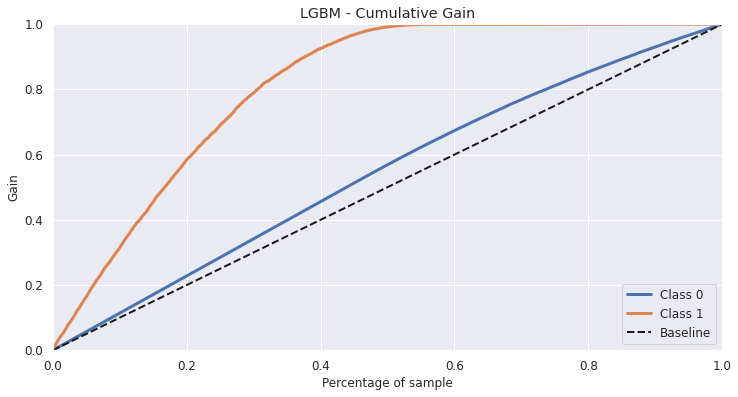

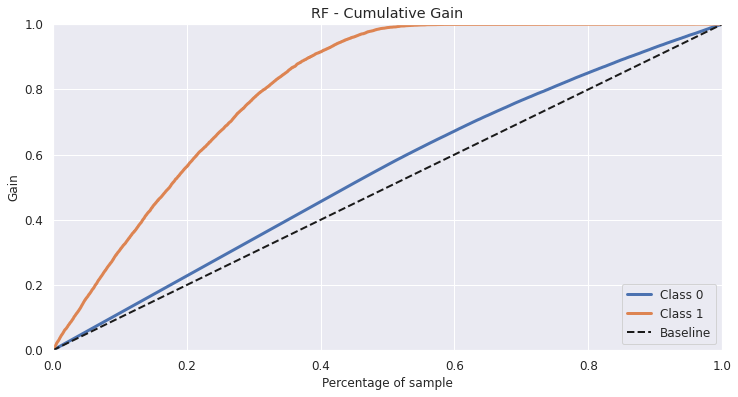

In [ ]:
skplt.metrics.plot_cumulative_gain( y_test, yhat_proba_lgbm, figsize = ( 12, 6 ), title = 'LGBM - Cumulative Gain' );
skplt.metrics.plot_cumulative_gain( y_test, yhat_proba_rf, figsize = ( 12, 6 ), title = 'RF - Cumulative Gain' );

### 9.5.4 Comparing Tunned Model's LIFT Curve

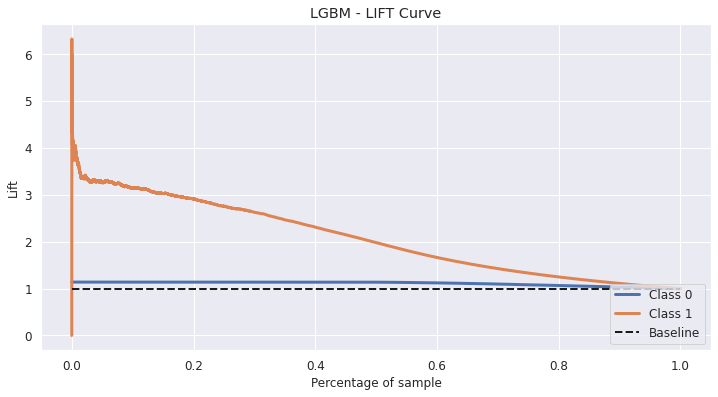

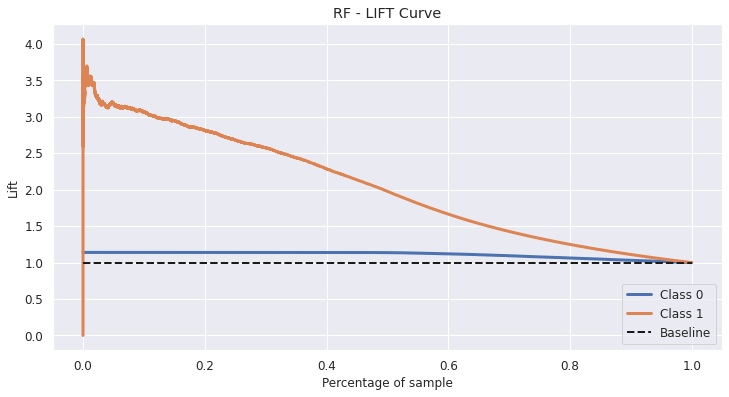

In [ ]:
skplt.metrics.plot_lift_curve( y_test, yhat_proba_lgbm, figsize = ( 12, 6 ), title = 'LGBM - LIFT Curve' );
skplt.metrics.plot_lift_curve( y_test, yhat_proba_rf, figsize = ( 12, 6 ), title = 'RF - LIFT Curve' );

### 9.5.5 Comparing Precision n' Recall

In [ ]:
precision_lgbm = precision_at_k( x_test, yhat_proba_lgbm, 'score', 0.2 )
recall_lgbm = recall_at_k( x_test, yhat_proba_lgbm, 'score', 0.2 )

precision_rf = precision_at_k( x_test, yhat_proba_rf, 'score', 0.2 )
recall_rf = recall_at_k( x_test, yhat_proba_rf, 'score', 0.2 )

print( 'LGBM Precision at K: {}'.format( precision_lgbm ) )
print( 'LGBM Recall at K: {}'.format( recall_lgbm ) )

print( '---------- ## ----------' )

print( 'RF Precision at K: {}'.format( precision_rf ) )
print( 'RF Recall at K: {}'.format( recall_rf ) )

LGBM Precision at K: 0.34704978375749646
LGBM Recall at K: 0.5743517918326224
---------- ## ----------
RF Precision at K: 0.3657191503291252
RF Recall at K: 0.6014934988693442


In [ ]:
proba = [yhat_proba_lgbm, yhat_proba_rf]
perc = [0.01, 0.1, 0.2, 0.4, 0.5]

In [ ]:
df_final_performance = pd.DataFrame()
df_final_performance = top_k_performance(x_test, proba, 'score', perc)
df_final_performance['Model'].loc[:4] = 'LGBM'
df_final_performance['Model'].loc[5:] = 'Random Forest'


In [ ]:
df_final_performance.sort_values(['Model', 'perc'], ascending=True)

,Model,perc,k,precision,recall,target_total,target_at_k,perc_target
0,LGBM,0.0100,571.0000,0.4544,0.0376,6952.0831,259.4904,0.0373
1,LGBM,0.1000,5716.0000,0.3829,0.3169,6908.9490,2188.9324,0.3168
2,LGBM,0.2000,11433.0000,0.3470,0.5744,6908.9490,3967.8826,0.5743
3,LGBM,0.4000,22866.0000,0.2794,0.9248,6908.9490,6389.0939,0.9248
4,LGBM,0.5000,28583.0000,0.2392,0.9894,6908.9490,6835.9180,0.9894
5,Random Forest,0.0100,571.0000,0.5329,0.0438,6908.9490,304.3365,0.0440
6,Random Forest,0.1000,5716.0000,0.4173,0.3431,6952.0831,2385.0663,0.3431
7,Random Forest,0.2000,11433.0000,0.3657,0.6015,6952.0831,4181.3549,0.6015
8,Random Forest,0.4000,22866.0000,0.2835,0.9325,6952.0831,6482.3800,0.9324
9,Random Forest,0.5000,28583.0000,0.2412,0.9916,6952.0831,6893.5161,0.9916


### 9.5.6 Final Considerations about what kind of Model to use

In [ ]:
pickle.dump( rf, open( '../model/Random_Forest_Model.pkl' , 'wb' ) )
pickle.dump( lgbm, open( '../model/LGBM_Model.pkl','wb' ) )

rf_size = os.stat( '../model/Random_Forest_Model.pkl' ).st_size / 1024
lgbm_size = os.stat( '../model/LGBM_Model.pkl' ).st_size / 1024

print( 'Random Forest model size: {0:.2f} KB'.format( rf_size ) )
print( 'LGBM model size: {0:.2f} KB'.format( lgbm_size ) )

Random Forest model size: 1664019.86 KB
LGBM model size: 238.20 KB


Como os modelos tem desempenhos semelhantes, optamos por utilizar o modelo de **LGBM** em produção, pois o **Random Forest** tem em torno de **7000 vezes** o tamanho do **LGBM**, portanto o custo de **storage** na **cloud** da empresa é minimizado.

### 9.5.7 Defining Threshold

In [ ]:
threshold = [0.1, 0.2, 0.25, 0.3, 0.31, 0.32, 0.325, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.5]
threshold_performance = pd.DataFrame()

for i in threshold:
    calc_threshold = lambda x: 0 if x < i else 1
    prediction = list( map( calc_threshold, yhat_proba_lgbm[:,1] ) )
    threshold_performance = threshold_performance.append( multi_class_metrics( i, y_test, prediction, 0 ) )

threshold_performance.reset_index().drop( ['index', 'Index'], axis=1 )

,Model,F1,Precision,Recall,Matthew Correlation
0,0.1000,0.4236,0.2724,0.9510,0.3949
1,0.2000,0.4585,0.3181,0.8207,0.4052
2,0.2500,0.4554,0.3364,0.7048,0.3830
3,0.3000,0.4289,0.3640,0.5219,0.3397
4,0.3100,0.4084,0.3727,0.4517,0.3183
5,0.3200,0.3888,0.3782,0.4000,0.3006
6,0.3250,0.3813,0.3842,0.3785,0.2954
7,0.3300,0.3690,0.3842,0.3550,0.2849
8,0.3400,0.3437,0.3864,0.3094,0.2652
9,0.3500,0.3232,0.3901,0.2758,0.2511


Vemos que um threshold bom para nosso modelo é um torno de **0.310** e **0.325**.

### 9.5.8 Saving all parameters and model

In [ ]:
pickle.dump( lgbm, open( '/content/drive/MyDrive/Colab/model/pa004/LGBM_Model.pkl', 'wb' ) )
pickle.dump( ss, open( '/content/drive/MyDrive/Colab/parameter/pa004/annual_premium_scaler.pkl', 'wb' ) )
pickle.dump( mms_age, open( '/content/drive/MyDrive/Colab/parameter/pa004/age_scaler.pkl', 'wb' ) )
pickle.dump( mms_vintage, open( '/content/drive/MyDrive/Colab/parameter/pa004/vintage_scaler.pkl', 'wb' ) )
pickle.dump( target_gender, open( '/content/drive/MyDrive/Colab/parameter/pa004/gender_scaler.pkl', 'wb' ) )
pickle.dump( target_region, open( '/content/drive/MyDrive/Colab/parameter/pa004/region_code_scaler.pkl', 'wb' ) )
pickle.dump( target_vehicle_age, open( '/content/drive/MyDrive/Colab/parameter/pa004/vehicle_age_scaler.pkl', 'wb' ) )
pickle.dump( fe_policy, open( '/content/drive/MyDrive/Colab/parameter/pa004/policy_sales_channel_scaler.pkl', 'wb' ) )

# 10.0. PASSO 10 - BUSINESS QUESTIONS

## 10.1 Insights Learned

### 1) Attributes Insights

Cerca de **12%** do dataset respondeu ter **interesse** no Cross-Sell proposto pela empresa **Insurance All**


---


A feature "**annual_premium**" tem um **RANGE** muito próximo do **MAX**, o que pode significar **presença de outliers** e devem ser estudados nos próximos ciclos.


---


Existem **features** que deveriam constar no **dataset** para um **melhor entendimento** e **desenvolvimento do modelo de negócio**, como mostrado na seção **2.2 Business Search** e isso deve ser reportado ao **time de negócio**.


---


A feature "**age**" nos mostra que existe uma preferencia maior pela oferta de Cross-Sell entre as idades de **40 e 50** anos.


---


A feature "**region_code**" nos mostra que existe uma preferencia maior pela oferta, porém **não temos detalhes suficientes** para especificar o porquê disso.


---


A feature "**vehicle_age**" nos mostra que existe uma preferência maior pela oferta de costumers que tem veículos entre **1 e 2 anos de idade**.


---


A feature "**policy_sales_channel**" nos mostra que existe uma preferência maior pela oferta, porém **não temos detalhes suficientes** para especificar o porquê disso também.


---


A feature "**vehicle_damage**" nos mostra que pessoas que **já sofreram danos** em seu carro estão mais interessadas pela oferta.


---


Pudemos observar, então, que as features que parecem ter importância são:

**1) annual_premium**

**2) previously_insured**

**3) vehicle_damage**

**4) age**

**5) vintage**

**6) policy_sales_channel**

**7) region_code**

## 10.2 Some possible questions asked by the CEO

### 10.2.1 Qual a **porcentagem de clientes**, interessados em adquirir o seguro de veículo, que o time de vendas conseguirá fazendo **5.000 ligações**? E qual **retorno financeiro**, se comparado ao **modelo randômico**, se cada seguro de veículo custar **1000 reais**?

In [ ]:
calls = 5000
total = x_test.shape[0]
perc_df = calls / total
resposta = top_k_performance( x_test, [yhat_proba_lgbm], 'score', [perc_df] )
print( 'O total de dados no dataset é {}'.format( total ) )
print( 'E 5000 calls representam {0:.2f}% do dataset'.format( perc_df*100 ) )
resposta['R$ LGBM Model'] = resposta['target_at_k'] * 1000
resposta['target_random'] = resposta['perc'] * resposta['target_total']
resposta['R$ Random Model'] = resposta['target_random'] * 1000
resposta['R$ Final'] = resposta['R$ LGBM Model'] - resposta['R$ Random Model']
resposta['% Final'] = resposta['R$ LGBM Model'] * 100 / resposta['R$ Random Model']
resposta[['k', 'perc_target', 'R$ LGBM Model', 'R$ Random Model', 'R$ Final', '% Final']]

O total de dados no dataset é 57167
E 5000 calls representam 8.75% do dataset


,k,perc_target,R$ LGBM Model,R$ Random Model,R$ Final,% Final
0,5000.0000,0.2812,1942733.8935,604277.7286,1338456.1649,321.4969


**R:**

Se ligarmos pra **5000 pessoas**, estaremos ligando para **8,75%** do nosso **dataset (x_test)** e teremos em torno de **28,1%** de todos os interessados possíveis.

Cerca de **3.21 vezes** mais do que o método randômico de seleção, de acordo com a **LIFT Curve** do modelo **LGBM**!!

Trazendo um retorno de **R$ 1.338.456** a mais que o randômico para a empresa!!

### 10.2.2 E se **aumentarmos** a quantidade de ligações para **10.000**?

In [ ]:
calls = 10000
perc_df = calls / total
resposta = top_k_performance( x_test, [yhat_proba_lgbm], 'score', [perc_df] )
print( 'O total de dados no dataset é {}'.format( total ) )
print( 'E 10000 calls representam {0:.2f}% do dataset'.format( perc_df*100 ) )
resposta['R$ LGBM Model'] = resposta['target_at_k'] * 1000
resposta['target_random'] = resposta['perc'] * resposta['target_total']
resposta['R$ Random Model'] = resposta['target_random'] * 1000
resposta['R$ Final'] = resposta['R$ LGBM Model'] - resposta['R$ Random Model']
resposta['% Final'] = resposta['R$ LGBM Model'] * 100 / resposta['R$ Random Model']
resposta[['k', 'perc_target', 'R$ LGBM Model', 'R$ Random Model', 'R$ Final', '% Final']]

O total de dados no dataset é 57167
E 10000 calls representam 17.49% do dataset


,k,perc_target,R$ LGBM Model,R$ Random Model,R$ Final,% Final
0,10000.0000,0.5136,3548660.8031,1208555.4572,2340105.3459,293.6283


**R:**

Se ligarmos pra **10000 pessoas**, estaremos ligando para **17,49%** do nosso **dataset (x_test)** e teremos em torno de **51,36%** de todos os interessados possíveis.

Cerca de **2.93 vezes** mais do que o método randômico de seleção, de acordo com a **LIFT Curve** do modelo **LGBM**!!

Trazendo um retorno de **R$ 2.340.105** a mais que o randômico para a empresa!!

### 10.2.3 E se agora, **aumentarmos** para **20.000** ligações?

In [ ]:
calls = 20000
perc_df = calls / total
resposta = top_k_performance( x_test, [yhat_proba_lgbm], 'score', [perc_df] )
print( 'O total de dados no dataset é {}'.format( total ) )
print( 'E 20000 calls representam {0:.2f}% do dataset'.format( perc_df*100 ) )
resposta['R$ LGBM Model'] = resposta['target_at_k'] * 1000
resposta['target_random'] = resposta['perc'] * resposta['target_total']
resposta['R$ Random Model'] = resposta['target_random'] * 1000
resposta['R$ Final'] = resposta['R$ LGBM Model'] - resposta['R$ Random Model']
resposta['% Final'] = resposta['R$ LGBM Model'] * 100 / resposta['R$ Random Model']
resposta[['k', 'perc_target', 'R$ LGBM Model', 'R$ Random Model', 'R$ Final', '% Final']]

O total de dados no dataset é 57167
E 20000 calls representam 34.99% do dataset


,k,perc_target,R$ LGBM Model,R$ Random Model,R$ Final,% Final
0,20000.0000,0.8632,5963700.0888,2417110.9143,3546589.1745,246.7284


**R:**

Se ligarmos pra **20000 pessoas**, estaremos ligando para **34,99%** do nosso **dataset (x_test)** e teremos em torno de **86,32%** de todos os interessados possíveis.

Cerca de **2.46 vezes** mais do que o método randômico de seleção, de acordo com a **LIFT Curve** do modelo **LGBM**!!

Trazendo um retorno de **R$ 3.546.589** a mais que o randômico para a empresa!!

# 11.0. PASSO 11 - DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [ ]:
import pickle
import pandas as pd
import numpy as np

class HealthInsurance( object ):

    def __init__( self ):
        self.home_path = ''
        self.annual_premium_scaler         = pickle.load( open( self.home_path + 'features/annual_premium_scaler.pkl','rb' ) )
        self.age_scaler                    = pickle.load( open( self.home_path + 'features/age_scaler.pkl','rb' ) )
        self.vintage_scaler                = pickle.load( open( self.home_path + 'features/vintage_scaler.pkl', 'rb' ) )
        self.gender_scaler                 = pickle.load( open( self.home_path + 'features/gender_scaler.pkl', 'rb' ) )
        self.region_code_scaler            = pickle.load( open( self.home_path + 'features/region_code_scaler.pkl', 'rb' ) )
        self.vehicle_age_scaler            = pickle.load( open( self.home_path + 'features/vehicle_age_scaler.pkl', 'rb' ) )
        self.policy_sales_channel_scaler   = pickle.load( open( self.home_path + 'features/policy_sales_channel_scaler.pkl', 'rb' ) )

    def data_cleaning( self, df ):
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
                    'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
                    'policy_sales_channel', 'vintage', 'response']
        df.columns = cols_new

        return df

    def feature_engineering( self, df ):
    
        df['region_code'] = df['region_code'].astype('int64')
        df['annual_premium'] = df['annual_premium'].astype('int64')
        df['policy_sales_channel'] = df['policy_sales_channel'].astype('int64')
        
        # vehicle age
        df['vehicle_age'] = df['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' if x == '1-2 Year' else 'below_1_year' )
    
        # vehicle damage
        df['vehicle_damage'] = df['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )
    
        return df

    def data_preparation( self, df ):
        # annual_premium
        df['annual_premium'] = self.annual_premium_scaler.transform( df[['annual_premium']].values )
    
        # age
        df['age'] = self.age_scaler.transform( df[['age']].values )
    
        # vintage
        df['vintage'] = self.vintage_scaler.transform( df[['vintage']].values )
    
        # gender - Frequency Encoding / *Target Encoding / Weighted Target ENcoding
        df.loc[:, 'gender'] = df['gender'].map( self.gender_scaler )
    
        # region_code - Frequency Encoding / *Target Encoding / Weighted Target ENcoding
        df.loc[:, 'region_code'] = df['region_code'].map( self.region_code_scaler )
        
        # vehicle_age - *One Hot Encoding / Order Encoding / Frequency Encoding / Target Encoding / Weighted Target ENcoding
        df.loc[:, 'vehicle_age'] = df['vehicle_age'].map( self.vehicle_age_scaler )
    
        # policy_sales_channel - Target Encoding / *Frequency Encoding
        df.loc[:, 'policy_sales_channel'] = df['policy_sales_channel'].map( self.policy_sales_channel_scaler )
        
        # select columns
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']
        
        df = df.fillna(0)

        return df[cols_selected]
    
    def get_prediction( self, model, original_data, test_data ):
        self.threshold = lambda x: 0 if x < 0.31 else 0
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original_data
        original_data['score'] = pred[:, 1].tolist()

        # sort_values
        original_data = original_data.sort_values( 'score', ascending = False )
    
        # threshold
        original_data.loc[:, 'score'] = original_data['score'].map( self.threshold )

        return original_data.to_json( orient='records', date_format='iso')

## 10.2 API Handler

In [ ]:
from crypt import methods
import os
import pickle
import pandas as pd
import lightgbm
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
model = pickle.load( open( 'model/LGBM_Model.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def healthinsurance_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique exemple
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple exemples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate HealthInsurance Class
        pipeline = HealthInsurance()
        
        # data cleaning
        df = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df = pipeline.feature_engineering( df )
        
        # data preparation
        df = pipeline.data_preparation( df )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( '0.0.0.0', port=port )

## 10.3 API Tester

In [ ]:
import pandas as pd
import numpy  as np
import pickle
import requests
import json

In [ ]:
df_raw = pd.read_csv( '/home/jocafneto/repositorio/allPAs/health_insurance/data/train.csv' )

df1 = df_raw.copy()

cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

df2 = df1.copy()

df3 = df2.copy()

df4 = df3.copy()

X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

# loading test dataset
df_test = x_validation
# df_test = df_test.drop(columns='response')
df_test['response'] = y_validation

df_test = df_test.sample(1)

df_test

# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

# API Call
url = 'https://health-insurance-score-27.herokuapp.com/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )


# return json to dataframe
d1 = pd.DataFrame( data=r.json(), columns=r.json()[0].keys() )

d2 = d1[['id', 'score']]

d2

d3 = pd.merge(df_test, d2, how='left', on='id')

d3